In [1]:
import pandas as pd
import pickle

In [2]:
# Extract ml info
df_extra_features_train_raw = pd.read_csv('../Data/ml_train.csv')
df_extra_features_test_raw = pd.read_csv('../Data/ml_test.csv')

In [3]:
df_extra_features_test_raw = pd.read_csv('../Data/ml_test.csv')# select those columns that Angel used to fit the ML models
selected_columns = ['study_id','site_id','bio01','bio02','bio05','bio08','bio14','ec','elevation','es','gHM','pdsi','soil_den_b10','moss','shrub','management','x0_1.0','x0_2.0','x0_4.0','x0_5.0','x0_7.0','x0_8.0','x0_10.0','x0_12.0']

df_extra_features_train = df_extra_features_train_raw[selected_columns]
df_extra_features_test = df_extra_features_test_raw[selected_columns]

# Note: it seems that these partitions are different from those used to calibrate DI-ML
# df_train.shape : (790, 25)
# df_test.shape : (217, 25)

df_ML_extra_features_info = pd.concat([df_extra_features_train, df_extra_features_test], ignore_index=True)

In [4]:
df_train_global_regressor = pd.read_csv('../Data/data_train_global_regressor_V0.csv')
df_test_global_regressor = pd.read_csv('../Data/data_test_global_regressor_V0.csv')

In [5]:
df_ML_train = df_train_global_regressor.merge(df_ML_extra_features_info, on=['study_id','site_id'], how='left')
df_ML_test = df_test_global_regressor.merge(df_ML_extra_features_info, on=['study_id','site_id'], how='left')

In [6]:
df_ML_train.to_csv('../Data/df_ML_train_global_regressor_V0.csv', index=False)
df_ML_test.to_csv('../Data/df_ML_test_global_regressor_V0.csv', index=False)

In [7]:
# sanity check
rows_with_na = df_ML_train.isna().any(axis=1)
number_rows_with_na = rows_with_na.sum()
print(number_rows_with_na) # 27 in the training set

# sanity check
rows_with_na = df_ML_test.isna().any(axis=1)
number_rows_with_na = rows_with_na.sum()
print(number_rows_with_na) # 20 in the test set

27
20


In [8]:
# Drop NAs from dataframes
df_ML_train_without_na = df_ML_train.dropna()
df_ML_test_without_na = df_ML_test.dropna()

In [9]:
# Create an iterator for cross validation
df_folds = pd.read_csv('../Data/CV_folds.csv')
df_ML_train_studyid_series = df_ML_train_without_na['study_id']
df_ML_train_studyid = df_ML_train_studyid_series.to_frame(name='study_id')
df_ML_train_folds = df_ML_train_studyid.merge(df_folds, on=['study_id'], how='left')

myCViterator = []
for i in range(0,5):
    trainIndices = df_ML_train_folds[df_ML_train_folds['fold'] != i].index.values.astype(int)
    testIndices = df_ML_train_folds[df_ML_train_folds['fold'] == i].index.values.astype(int)
    myCViterator.append((trainIndices, testIndices))

# Save iterator    
with open('../Data/myCViterator_PREVENT.pkl', 'wb') as f:
    pickle.dump(myCViterator, f)


In [10]:
# Import our cv iterator (K-Folds)
with open('../Data/myCViterator_PREVENT.pkl', 'rb') as file:
        myCViterator = pickle.load(file)

In [13]:
import numpy as np
from sklearn.linear_model import BayesianRidge
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import spearmanr, uniform
from sklearn.preprocessing import StandardScaler

X_columns_CNN = ['global_regressor_V0','bio01','bio02','bio05','bio08','bio14','ec','elevation','es','gHM','pdsi','soil_den_b10','moss','shrub','management_y','x0_1.0','x0_2.0','x0_4.0','x0_5.0','x0_7.0','x0_8.0','x0_10.0','x0_12.0']
X_columns_NO_CNN = ['bio01','bio02','bio05','bio08','bio14','ec','elevation','es','gHM','pdsi','soil_den_b10','moss','shrub','management_y','x0_1.0','x0_2.0','x0_4.0','x0_5.0','x0_7.0','x0_8.0','x0_10.0','x0_12.0']

y_columns = ['log_vr_total']

X_train_CNN = df_ML_train_without_na[X_columns_CNN]
X_train_NO_CNN = df_ML_train_without_na[X_columns_NO_CNN]
X_test_CNN = df_ML_test_without_na[X_columns_CNN]
X_test_NO_CNN = df_ML_test_without_na[X_columns_NO_CNN]

# Seleccionar las columnas por nombre
columnas_a_escalar_CNN = ['global_regressor_V0','bio01','bio02','bio05','bio08','bio14','ec','elevation','es','gHM','pdsi','soil_den_b10','moss','shrub']
columnas_a_escalar_NO_CNN = ['bio01','bio02','bio05','bio08','bio14','ec','elevation','es','gHM','pdsi','soil_den_b10','moss','shrub']

# Crear una instancia de StandardScaler
scaler_CNN = StandardScaler()
scaler_NO_CNN = StandardScaler()

# Ajustar el scaler solo con los datos de entrenamiento y luego transformar los datos de entrenamiento
X_train_CNN[columnas_a_escalar_CNN] = scaler_CNN.fit_transform(X_train_CNN[columnas_a_escalar_CNN])
X_train_NO_CNN[columnas_a_escalar_NO_CNN] = scaler_NO_CNN.fit_transform(X_train_NO_CNN[columnas_a_escalar_NO_CNN])

# Aplicar la transformación a los datos de prueba usando los valores ajustados de los datos de entrenamiento
X_test_CNN[columnas_a_escalar_CNN] = scaler_CNN.transform(X_test_CNN[columnas_a_escalar_CNN])
X_test_NO_CNN[columnas_a_escalar_NO_CNN] = scaler_NO_CNN.transform(X_test_NO_CNN[columnas_a_escalar_NO_CNN])

y_train = df_ML_train_without_na[y_columns]
y_test = df_ML_test_without_na[y_columns]

C:\Users\alfon\AppData\Local\Temp\ipykernel_24916\2044280784.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_CNN[columnas_a_escalar_CNN] = scaler_CNN.fit_transform(X_train_CNN[columnas_a_escalar_CNN])
C:\Users\alfon\AppData\Local\Temp\ipykernel_24916\2044280784.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_NO_CNN[columnas_a_escalar_NO_CNN] = scaler_NO_CNN.fit_transform(X_train_NO_CNN[columnas_a_escalar_NO_CNN])
C:\Users\alfon\AppData\Local\Temp\ipykernel_24916\2044280784.py:32: S

In [14]:
# Model definition
model_bayesian_ridge = BayesianRidge(n_iter=25000)

# Definir la cuadrícula de hiperparámetros a explorar
param_grid = {
    'alpha_1': uniform(loc=0, scale=1),
    'alpha_2': uniform(loc=0, scale=1),
    'lambda_1': uniform(loc=0, scale=1),
    'lambda_2': uniform(loc=0, scale=1),
    'fit_intercept': [False, True]
}

# Cross validation strategy (here we use K-Fold)
cv = KFold(n_splits = 5, shuffle = True, random_state = 42)

# Random search of best hyperparameter combinations
grid_search = RandomizedSearchCV(model_bayesian_ridge, param_distributions = param_grid, cv = myCViterator,
                            scoring = 'neg_mean_absolute_error', n_iter = 10000,
                            verbose = 2, random_state = 135, n_jobs = 8)

grid_search.fit(X_train_CNN, y_train)

# best hyperparameter combination
best_hyperparameters_CNN = grid_search.best_params_

# best model
best_model_CNN = grid_search.best_estimator_


Fitting 5 folds for each of 10000 candidates, totalling 50000 fits


C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\linear_model\_bayes.py:53: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.3 and will be removed in 1.5
  warnings.warn(
C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [15]:
best_model_CNN

BayesianRidge(alpha_1=0.2226205582312254, alpha_2=0.8878763707771585,
              lambda_1=0.9027741603701731, lambda_2=0.0019529592485052483,
              n_iter=25000)

In [16]:
# make predictions
y_pred_CNN = best_model_CNN.predict(X_test_CNN)

# Evaluation of our best model
mae = mean_absolute_error(y_test, y_pred_CNN)
mse = mean_squared_error(y_test, y_pred_CNN)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_CNN)

# Estimate spearman rho
coef_spearman, p_valor_spearman = spearmanr(y_test, y_pred_CNN)

# Best model results
# print("Model coefficients:", best_model_CNN.coef_)
# print("Intercept:", best_model_CNN.intercept_)
print("Mean square error (MSE):", mse)
print("Root mean square error (RMSE):", rmse)
print("Mean absolute error (MAE):", mae)
print("R-squared:", r2)
print("Spearman-rho:", coef_spearman,"(pvalor:",p_valor_spearman,")")


Mean square error (MSE): 1.6853400588201395
Root mean square error (RMSE): 1.2982064777300024
Mean absolute error (MAE): 1.052785577412645
R-squared: 0.17676727795535352
Spearman-rho: 0.4843584448928614 (pvalor: 3.3848375282699367e-10 )


In [198]:
# Results for global regressor V0

# MSE: 2.108320951461792
# RMSE: 1.4520058631896973
# MAE: 1.1913878917694092

# R^2: 0.12594198646820398
# Spearman's rho: 0.4399167953903466

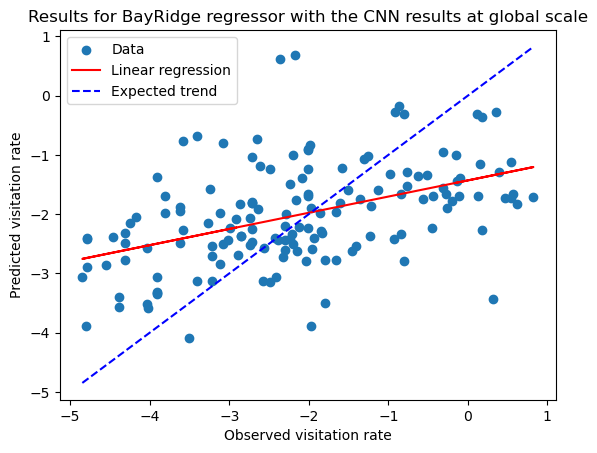

In [17]:
import matplotlib.pyplot as plt
import numpy as np

y_true = y_test.to_numpy()
y_true_array = y_true.flatten()
# fit a regression line with numpy
coef = np.polyfit(y_true_array, y_pred_CNN, 1)
poly1d_fn = np.poly1d(coef)

# create a scatter plot with regression line
plt.scatter(y_true_array, y_pred_CNN, label='Data')
plt.plot(y_true_array, poly1d_fn(y_true_array), color = 'red', label = 'Linear regression')
plt.plot(sorted(y_true_array), sorted(y_true_array), color = 'blue', linestyle = '--', label = 'Expected trend')

# Add labels
plt.xlabel('Observed visitation rate')
plt.ylabel('Predicted visitation rate')
plt.title('Results for BayRidge regressor with the CNN results at global scale')

# show legend
plt.legend()

# show plot
plt.show()

global_regressor_V0: VIP = 21.677679132463656
bio08: VIP = 4.229522217819491
bio01: VIP = 4.0698795908826115
elevation: VIP = 3.8377795127501773
x0_5.0: VIP = 3.8299796351643702
management_y: VIP = 3.088032657434793
bio14: VIP = 2.98834307149002
x0_1.0: VIP = 2.810110524727909
x0_10.0: VIP = 2.544886286808317
moss: VIP = 2.474583734096944
x0_2.0: VIP = 2.431750943224291
soil_den_b10: VIP = 1.6384393829844042
bio02: VIP = 1.3644281413919321
ec: VIP = 1.2487112629394068
pdsi: VIP = 1.1582171488193114
es: VIP = 0.9034629766978131
gHM: VIP = 0.9004103407425345
shrub: VIP = 0.8079097609151931
x0_4.0: VIP = 0.7849206957094972
x0_12.0: VIP = 0.6661114707041579
x0_7.0: VIP = 0.5520386169070413
bio05: VIP = 0.3486563157030191
x0_8.0: VIP = 0.2358859249400958


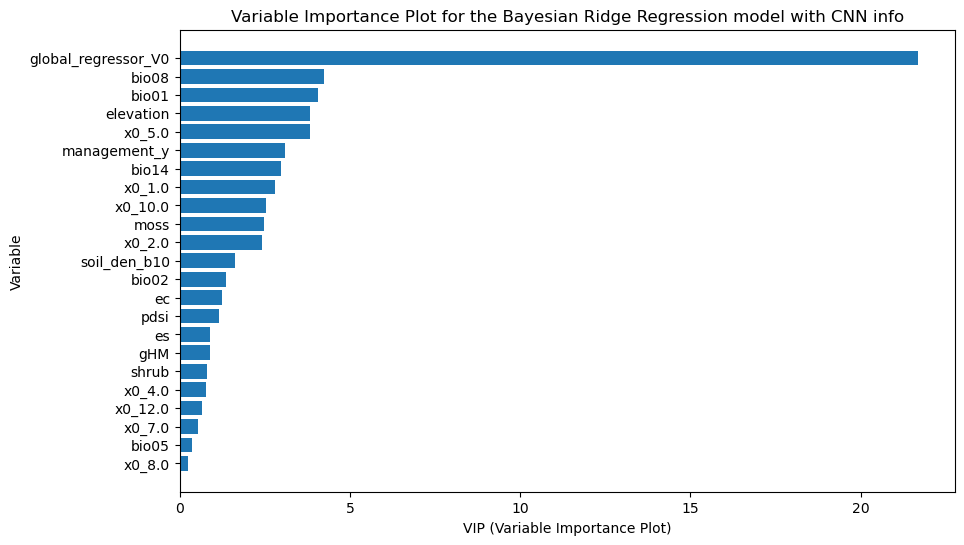

In [18]:
# Get coef. from the best model estimated
coeficients = best_model_CNN.coef_

# Get variance from the estimated coeficients
variance_coefs = np.var(coeficients)

# Estimate VIP for each variable
VIP = np.abs(coeficients) / variance_coefs

# Sort VIP
sorted_indices = np.argsort(VIP)[::-1]  # Sort from larger to smaller VIP
sorted_VIP = VIP[sorted_indices]

# Print VIP
for i, idx in enumerate(sorted_indices):
    print(f"{X_columns_CNN[idx]}: VIP = {sorted_VIP[i]}")
    
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_indices)), sorted_VIP, align='center')
plt.yticks(range(len(sorted_indices)), [X_columns_CNN[i] for i in sorted_indices])
plt.xlabel('VIP (Variable Importance Plot)')
plt.ylabel('Variable')
plt.title('Variable Importance Plot for the Bayesian Ridge Regression model with CNN info')
plt.gca().invert_yaxis()  # Invertir el eje y para que las variables más importantes estén arriba
plt.show()

In [ ]:
# Y si pasamos a elastic net para evitar variables que aporten poco?

In [256]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Definir el modelo ElasticNet
model_elasticnet = ElasticNet(max_iter=25000)

# Definir la cuadrícula de hiperparámetros a explorar
param_grid_elastic = {
    'alpha': uniform(loc=0, scale=1),  # Constante que multiplica los términos de penalización
    'l1_ratio': uniform(loc=0, scale=1),  # Parámetro de mezcla de ElasticNet, con 0 <= l1_ratio <= 1
    'fit_intercept': [False, True],  # Si se debe calcular el intercepto para este modelo o no
    'max_iter': [50000],  # Número máximo de iteraciones
    'selection': ['cyclic', 'random']  # Si se debe usar selección cíclica o aleatoria de las características
}

# Búsqueda aleatoria de la mejor combinación de hiperparámetros
grid_search_elastic = RandomizedSearchCV(model_elasticnet, param_distributions=param_grid_elastic, cv=myCViterator,
                                 scoring='neg_mean_absolute_error', n_iter=25000,
                                 verbose=2, random_state=135, n_jobs=8)

# Ajustar el modelo a los datos de entrenamiento
grid_search_elastic.fit(X_train_CNN, y_train)

# Mejor combinación de hiperparámetros
best_hyperparameters_CNN_elastic = grid_search_elastic.best_params_

# Mejor modelo
best_model_CNN_elastic = grid_search_elastic.best_estimator_

Fitting 5 folds for each of 25000 candidates, totalling 125000 fits


In [257]:
best_model_CNN_elastic

ElasticNet(alpha=0.0811561222045698, l1_ratio=0.9929802392289443,
           max_iter=50000, selection='random')

In [258]:
# make predictions
y_pred_CNN_elastic = best_model_CNN_elastic.predict(X_test_CNN)

# Evaluation of our best model
mae_elastic = mean_absolute_error(y_test, y_pred_CNN_elastic)
mse_elastic = mean_squared_error(y_test, y_pred_CNN_elastic)
rmse_elastic = np.sqrt(mse_elastic)
r2_elastic = r2_score(y_test, y_pred_CNN_elastic)

# Estimate spearman rho
coef_spearman_elastic, p_valor_spearman_elastic = spearmanr(y_test, y_pred_CNN_elastic)

# Best model results
# print("Model coefficients:", best_model_CNN.coef_)
# print("Intercept:", best_model_CNN.intercept_)
print("Mean square error (MSE):", mse_elastic)
print("Root mean square error (RMSE):", rmse_elastic)
print("Mean absolute error (MAE):", mae_elastic)
print("R-squared:", r2_elastic)
print("Spearman-rho:", coef_spearman_elastic,"(pvalor:",p_valor_spearman_elastic,")")

Mean square error (MSE): 1.7178702906091052
Root mean square error (RMSE): 1.3106755092734073
Mean absolute error (MAE): 1.0628186337223549
R-squared: 0.1608773386376342
Spearman-rho: 0.46008316330597776 (pvalor: 3.15630031404102e-09 )


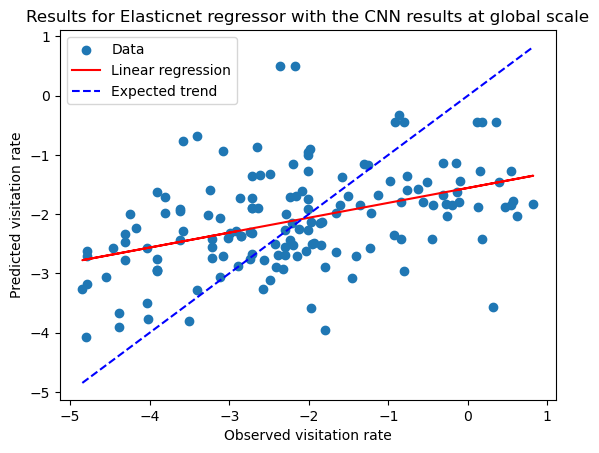

In [259]:
import matplotlib.pyplot as plt
import numpy as np

y_true = y_test.to_numpy()
y_true_array = y_true.flatten()
# fit a regression line with numpy
coef_elastic = np.polyfit(y_true_array, y_pred_CNN_elastic, 1)
poly1d_fn_elastic = np.poly1d(coef_elastic)

# create a scatter plot with regression line
plt.scatter(y_true_array, y_pred_CNN_elastic, label='Data')
plt.plot(y_true_array, poly1d_fn_elastic(y_true_array), color = 'red', label = 'Linear regression')
plt.plot(sorted(y_true_array), sorted(y_true_array), color = 'blue', linestyle = '--', label = 'Expected trend')

# Add labels
plt.xlabel('Observed visitation rate')
plt.ylabel('Predicted visitation rate')
plt.title('Results for Elasticnet regressor with the CNN results at global scale')

# show legend
plt.legend()

# show plot
plt.show()

global_regressor_V0: VIP = 21.677678989651398
bio08: VIP = 4.22952229462742
management_y: VIP = 3.0880325801966455
bio01: VIP = 4.0698794256133075
elevation: VIP = 3.8377793926394967
soil_den_b10: VIP = 1.6384393087799203
x0_2.0: VIP = 2.4317509263490824
x0_5.0: VIP = 3.829979607409194
x0_8.0: VIP = 0.23588560557647975
bio02: VIP = 1.364428067920219
bio05: VIP = 0.348656292174612
x0_7.0: VIP = 0.5520387908408567
bio14: VIP = 2.9883429915868542
ec: VIP = 1.2487108990665978
es: VIP = 0.9034629003125042
x0_1.0: VIP = 2.8101106843468093
gHM: VIP = 0.9004104621233516
pdsi: VIP = 1.1582171519427649
x0_10.0: VIP = 2.544886064427829
moss: VIP = 2.474583717009505
shrub: VIP = 0.8079097346324443
x0_4.0: VIP = 0.7849206236821082
x0_12.0: VIP = 0.6661112351158202


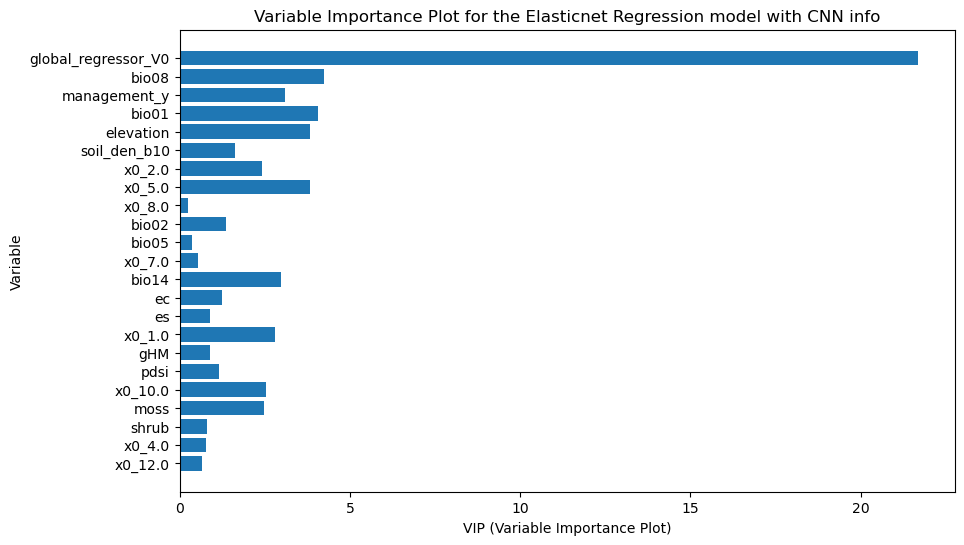

In [254]:
# Get coef. from the best model estimated
coeficients_elastic = best_model_CNN_elastic.coef_

# Get variance from the estimated coeficients
variance_coefs_elastic = np.var(coeficients_elastic)

# Estimate VIP for each variable
VIP_elastic = np.abs(coeficients_elastic) / variance_coefs_elastic

# Sort VIP
sorted_indices_elastic = np.argsort(VIP_elastic)[::-1]  # Sort from larger to smaller VIP
sorted_VIP_elastic = VIP[sorted_indices_elastic]

# Print VIP
for i, idx in enumerate(sorted_indices_elastic):
    print(f"{X_columns_CNN[idx]}: VIP = {sorted_VIP_elastic[i]}")
    
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_indices_elastic)), sorted_VIP_elastic, align='center')
plt.yticks(range(len(sorted_indices_elastic)), [X_columns_CNN[i] for i in sorted_indices_elastic])
plt.xlabel('VIP (Variable Importance Plot)')
plt.ylabel('Variable')
plt.title('Variable Importance Plot for the Elasticnet Regression model with CNN info')
plt.gca().invert_yaxis()  # Invertir el eje y para que las variables más importantes estén arriba
plt.show()

In [ ]:
# y usando grandient boost??

In [245]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform, randint

# Definir el espacio de hiperparámetros a explorar
param_dist = {
    'loss': ['ls', 'lad', 'huber', 'quantile'],
    'learning_rate': uniform(loc=0, scale=.1),
    'n_estimators': randint(50, 600),  # Utilizamos randint para valores enteros en un rango
    'subsample': uniform(loc=0, scale=1), #[1],
    'min_samples_split': uniform(loc=0, scale=1),
    'min_samples_leaf': uniform(loc=0, scale=0.5),
    'min_weight_fraction_leaf': uniform(loc=0, scale=0.5),
    'max_depth': [2, 4, 8, 16, 32], #[2, 4, 8, 32, 64, 128], #
    'min_impurity_decrease': uniform(loc=0, scale=1),
    'max_features': uniform(loc=0, scale=1),
    'alpha': uniform(loc=0, scale=1),
    'max_leaf_nodes': [8, 16, 32, 64],
    'ccp_alpha': uniform(loc=0, scale=1)
}
# Crear una instancia del modelo Gradient Boosting
model = GradientBoostingRegressor()

# Número de iteraciones aleatorias
n_iter = 25000

# Crear un objeto RandomizedSearchCV para búsqueda aleatoria
random_search_GB_CNN = RandomizedSearchCV(model, param_distributions=param_dist, cv = myCViterator, scoring='neg_mean_absolute_error', n_iter= n_iter,verbose=2, random_state=135, n_jobs=8)

# Realizar la búsqueda aleatoria en el espacio de hiperparámetros
random_search_GB_CNN.fit(X_train_CNN, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params_GB_CNN = random_search_GB_CNN.best_params_
print(f"Mejores hiperparámetros: {random_search_GB_CNN}")

# Obtener el mejor modelo ajustado
best_model_GB_CNN = random_search_GB_CNN.best_estimator_

Fitting 5 folds for each of 25000 candidates, totalling 125000 fits


C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
62660 fits failed out of a total of 125000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7878 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\alfon\anaconda3\Lib\site-

C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan ... -1.18103828 -1.18042674
         nan]
  warnings.warn(
C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mejores hiperparámetros: RandomizedSearchCV(cv=[(array([  0,   1,   2,   3,   4,   5,   6,   7,  17,  18,  19,  20,  21,
        22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,
        35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
        48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
        61,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,...
                                        'min_weight_fraction_leaf': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000178C8CE1AD0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000178FD9AA950>,
                                        'subsample': <scipy.stats._distn_inf

In [246]:
# make predictions
y_pred_GB_CNN = best_model_GB_CNN.predict(X_test_CNN)

# Evaluation of our best model
mae_GB_CNN = mean_absolute_error(y_test, y_pred_GB_CNN)
mse_GB_CNN = mean_squared_error(y_test, y_pred_GB_CNN)
rmse_GB_CNN = np.sqrt(mse_GB_CNN)
r2_GB_CNN = r2_score(y_test, y_pred_GB_CNN)

# Estimate spearman rho
coef_spearman_GB_CNN, p_valor_spearman_GB_CNN = spearmanr(y_test, y_pred_GB_CNN)

# Best model results
# print("Model coefficients:", best_model_NO_CNN.coef_)
# print("Intercept:", best_model_NO_CNN.intercept_)
print("Mean square error (MSE):", mse_GB_CNN)
print("Root mean square error (RMSE):", rmse_GB_CNN)
print("R-squared:", r2_GB_CNN)
print("Mean absolute error (MAE):", mae_GB_CNN)
print("Spearman-rho:", coef_spearman_GB_CNN,"(pvalor:",p_valor_spearman_GB_CNN,")")

Mean square error (MSE): 1.619964255214165
Root mean square error (RMSE): 1.2727781641802962
R-squared: 0.20870118973579277
Mean absolute error (MAE): 1.0455589553473885
Spearman-rho: 0.4540819774169178 (pvalor: 5.3386643115838766e-09 )


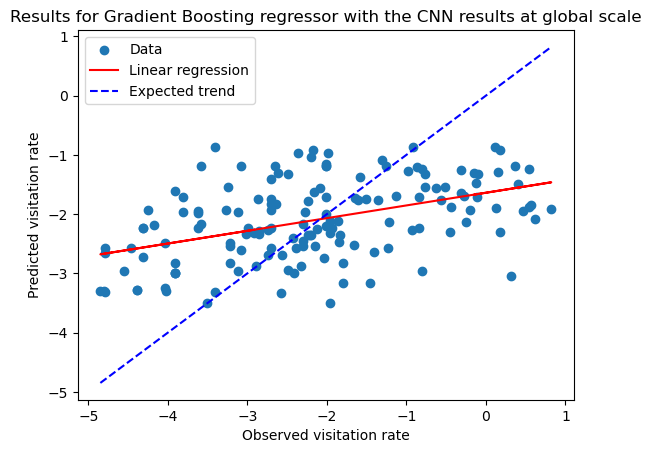

In [247]:
import matplotlib.pyplot as plt
import numpy as np

y_test_1d_GB_CNN = y_test.numpy().flatten() if isinstance(y_test, torch.Tensor) else np.array(y_test).flatten()

# fit a regression line with numpy
coef_GB_CNN = np.polyfit(y_test_1d_GB_CNN, y_pred_GB_CNN, 1)
poly1d_fn_GB_CNN = np.poly1d(coef_GB_CNN)

# create a scatter plot with regression line
plt.scatter(y_test_1d_GB_CNN, y_pred_GB_CNN, label='Data')
plt.plot(y_test_1d_GB_CNN, poly1d_fn_GB_CNN(y_test_1d_GB_CNN), color = 'red', label = 'Linear regression')
plt.plot(sorted(y_test_1d_GB_CNN), sorted(y_test_1d_GB_CNN), color = 'blue', linestyle = '--', label = 'Expected trend')

# Add labels
plt.xlabel('Observed visitation rate')
plt.ylabel('Predicted visitation rate')
plt.title('Results for Gradient Boosting regressor with the CNN results at global scale')

# show legend
plt.legend()

# show plot
plt.show()

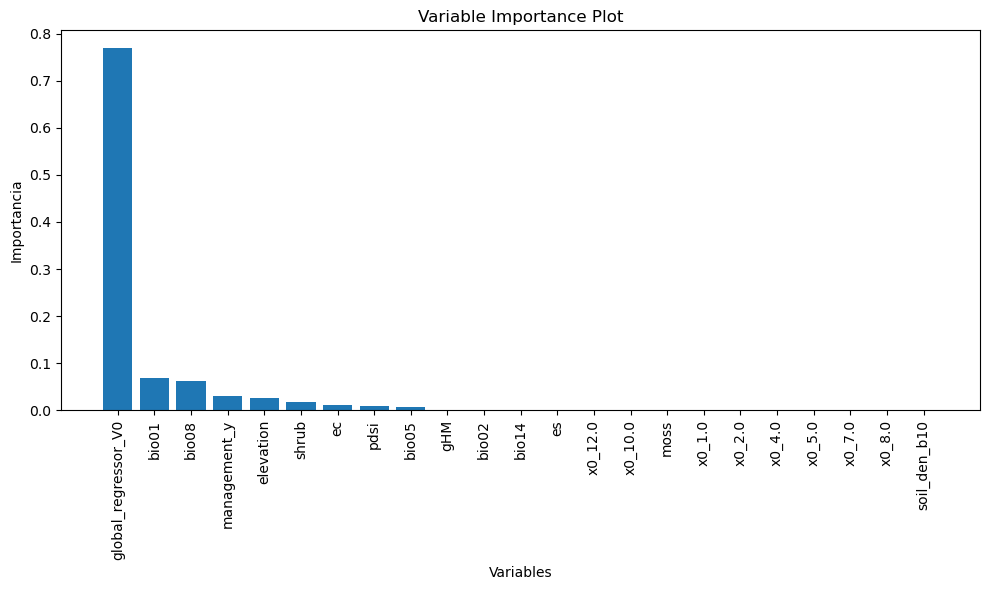

In [249]:
# Paso 2: Obtén la importancia de las variables desde el modelo
feature_importance_GB_CNN = best_model_GB_CNN.feature_importances_

# Paso 3: Crea un gráfico de barras para visualizar la importancia de las variables
# Puedes ordenar las variables por importancia si lo deseas
sorted_idx_GB_CNN = np.argsort(feature_importance_GB_CNN)[::-1]  # Orden descendente

# Obtén los nombres de las características (columnas) si los tienes
feature_names_GB_CNN = list(X_train_CNN.columns)  # Reemplaza con tus nombres de características reales

# Crea el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_idx_GB_CNN)), feature_importance_GB_CNN[sorted_idx_GB_CNN], align='center')
plt.xticks(range(len(sorted_idx_GB_CNN)), [feature_names_GB_CNN[i] for i in sorted_idx_GB_CNN], rotation=90)
plt.xlabel('Variables')
plt.ylabel('Importancia')
plt.title('Variable Importance Plot')
plt.tight_layout()
plt.show()

In [ ]:
# Y si eliminamos varibales altamente correlacionadas antes de ajustar el modelo?

In [216]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df, columns):
    vif_data = pd.DataFrame()
    vif_data["feature"] = columns
    vif_data["VIF"] = [variance_inflation_factor(df[columns].values, i) for i in range(len(columns))]
    return vif_data

X_columns_CNN_raw = ['global_regressor_V0','bio01','bio02','bio05','bio08','bio14','ec','elevation','es','gHM','pdsi','soil_den_b10','moss','shrub','management_y','x0_1.0','x0_2.0','x0_4.0','x0_5.0','x0_7.0','x0_8.0','x0_10.0','x0_12.0']
X_columns_NO_CNN_raw = ['bio01','bio02','bio05','bio08','bio14','ec','elevation','es','gHM','pdsi','soil_den_b10','moss','shrub','management_y','x0_1.0','x0_2.0','x0_4.0','x0_5.0','x0_7.0','x0_8.0','x0_10.0','x0_12.0']

y_columns = ['log_vr_total']

X_train_CNN_raw = df_ML_train_without_na[X_columns_CNN_raw]
X_train_NO_CNN_raw = df_ML_train_without_na[X_columns_NO_CNN_raw]
X_test_CNN_raw = df_ML_test_without_na[X_columns_CNN_raw]
X_test_NO_CNN_raw = df_ML_test_without_na[X_columns_NO_CNN_raw]


# Calcular VIF para X_train_CNN
vif_CNN = calculate_vif(X_train_CNN_raw, X_columns_CNN_raw)
print("VIF para X_train_CNN:")
print(vif_CNN)

# Calcular VIF para X_train_NO_CNN
vif_NO_CNN = calculate_vif(X_train_NO_CNN_raw, X_columns_NO_CNN_raw)
print("VIF para X_train_NO_CNN:")
print(vif_NO_CNN)

VIF para X_train_CNN:
                feature        VIF
0   global_regressor_V0   1.804361
1                 bio01  13.336954
2                 bio02   6.033153
3                 bio05  12.324574
4                 bio08   3.457263
5                 bio14   2.121200
6                    ec   7.421942
7             elevation   6.482249
8                    es   3.007624
9                   gHM   2.863368
10                 pdsi   1.968357
11         soil_den_b10   3.178869
12                 moss   1.405711
13                shrub   3.457373
14         management_y   1.605233
15               x0_1.0  12.552840
16               x0_2.0   2.498524
17               x0_4.0   9.820419
18               x0_5.0   3.339167
19               x0_7.0   3.314832
20               x0_8.0   2.931238
21              x0_10.0   2.473111
22              x0_12.0   3.278426
VIF para X_train_NO_CNN:
         feature        VIF
0          bio01  13.126806
1          bio02   5.688380
2          bio05  12.310339
3

In [217]:
# Definir un umbral para VIF
vif_threshold = 8

# Filtrar las columnas que tienen VIF menor que el umbral
selected_columns_CNN_raw = vif_CNN[vif_CNN["VIF"] < vif_threshold]["feature"].tolist()
selected_columns_NO_CNN_raw = vif_NO_CNN[vif_NO_CNN["VIF"] < vif_threshold]["feature"].tolist()

# Crear nuevos DataFrames con las columnas seleccionadas
X_train_CNN_raw_reduced = X_train_CNN_raw[selected_columns_CNN_raw]
X_train_NO_CNN_raw_reduced = X_train_NO_CNN_raw[selected_columns_NO_CNN_raw]
X_test_CNN_raw_reduced = X_test_CNN_raw[selected_columns_CNN_raw]
X_test_NO_CNN_raw_reduced = X_test_NO_CNN_raw[selected_columns_NO_CNN_raw]

print("Columnas seleccionadas para X_train_CNN:", selected_columns_CNN_raw)
print("Columnas seleccionadas para X_train_NO_CNN:", selected_columns_NO_CNN_raw)

Columnas seleccionadas para X_train_CNN: ['global_regressor_V0', 'bio02', 'bio08', 'bio14', 'ec', 'elevation', 'es', 'gHM', 'pdsi', 'soil_den_b10', 'moss', 'shrub', 'management_y', 'x0_2.0', 'x0_5.0', 'x0_7.0', 'x0_8.0', 'x0_10.0', 'x0_12.0']
Columnas seleccionadas para X_train_NO_CNN: ['bio02', 'bio08', 'bio14', 'ec', 'elevation', 'es', 'gHM', 'pdsi', 'soil_den_b10', 'moss', 'shrub', 'management_y', 'x0_2.0', 'x0_4.0', 'x0_5.0', 'x0_7.0', 'x0_8.0', 'x0_10.0', 'x0_12.0']


In [269]:
# Crear una instancia de StandardScaler
scaler_CNN_raw = StandardScaler()
scaler_NO_CNN_raw = StandardScaler()

# Ajustar el scaler solo con los datos de entrenamiento y luego transformar los datos de entrenamiento
X_train_CNN_raw_reduced_sc = scaler_CNN_raw.fit_transform(X_train_CNN_raw_reduced)
X_train_NO_CNN_raw_reduced_sc = scaler_NO_CNN_raw.fit_transform(X_train_NO_CNN_raw_reduced)

In [270]:
grid_search.fit(X_train_CNN_raw_raw_reduced_sc, y_train)

# best hyperparameter combination
best_hyperparameters_CNN = grid_search.best_params_

# best model
best_model_CNN_reduced = grid_search.best_estimator_

Fitting 5 folds for each of 10000 candidates, totalling 50000 fits


C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\linear_model\_bayes.py:53: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.3 and will be removed in 1.5
  warnings.warn(
C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [272]:
# make predictions
y_pred_CNN_raw_reduced = best_model_CNN_reduced.predict(X_test_CNN_raw_reduced)

# Evaluation of our best model
mae_raw_reduced = mean_absolute_error(y_test, y_pred_CNN_raw_reduced)
mse_raw_reduced = mean_squared_error(y_test, y_pred_CNN_raw_reduced)
rmse_raw_reduced = np.sqrt(mse_raw_reduced)
r2_raw_reduced = r2_score(y_test, y_pred_CNN_raw_reduced)

# Estimate spearman rho
coef_spearman_raw_reduced, p_valor_spearman_raw_reduced = spearmanr(y_test, y_pred_CNN_raw_reduced)

# Best model results
# print("Model coefficients:", best_model_CNN.coef_)
# print("Intercept:", best_model_CNN.intercept_)
print("Mean square error (MSE):", mse_raw_reduced)
print("Root mean square error (RMSE):", rmse_raw_reduced)
print("Mean absolute error (MAE):", mae_raw_reduced)
print("R-squared:", r2_raw_reduced)
print("Spearman-rho:", coef_spearman_raw_reduced,"(pvalor:",p_valor_spearman_raw_reduced,")")

Mean square error (MSE): 4.960576639352256
Root mean square error (RMSE): 2.2272352007258363
Mean absolute error (MAE): 1.8923804366802233
R-squared: -1.4230771637766302
Spearman-rho: 0.47574376378648864 (pvalor: 7.626853682587354e-10 )


C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but BayesianRidge was fitted without feature names
  warnings.warn(


In [ ]:
# Está metiendo ruido la prediccion de las CNNs??? Posiblemente sí

In [19]:
# Fit model without CNN info (global regressor)
grid_search.fit(X_train_NO_CNN, y_train)

# best hyperparameter combination
best_hyperparameters_NO_CNN = grid_search.best_params_

# best model
best_model_NO_CNN = grid_search.best_estimator_


Fitting 5 folds for each of 10000 candidates, totalling 50000 fits


C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\linear_model\_bayes.py:53: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.3 and will be removed in 1.5
  warnings.warn(
C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [26]:
best_model_NO_CNN

BayesianRidge(alpha_1=0.2226205582312254, alpha_2=0.8878763707771585,
              lambda_1=0.9027741603701731, lambda_2=0.0019529592485052483,
              n_iter=25000)

In [27]:
# make predictions
y_pred_NO_CNN = best_model_NO_CNN.predict(X_test_NO_CNN)

# Evaluation of our best model
mae_NO_CNN = mean_absolute_error(y_test, y_pred_NO_CNN)
mse_NO_CNN = mean_squared_error(y_test, y_pred_NO_CNN)
rmse_NO_CNN = np.sqrt(mse_NO_CNN)
r2_NO_CNN = r2_score(y_test, y_pred_NO_CNN)

# Estimate spearman rho
coef_spearman_NO_CNN, p_valor_spearman_NO_CNN = spearmanr(y_test, y_pred_NO_CNN)

# Best model results
# print("Model coefficients:", best_model_NO_CNN.coef_)
# print("Intercept:", best_model_NO_CNN.intercept_)
print("Mean square error (MSE):", mse_NO_CNN)
print("Root mean square error (RMSE):", rmse_NO_CNN)
print("R-squared:", r2_NO_CNN)
print("Mean absolute error (MAE):", mae_NO_CNN)
print("Spearman-rho:", coef_spearman_NO_CNN,"(pvalor:",p_valor_spearman_NO_CNN,")")

Mean square error (MSE): 1.2383232943900047
Root mean square error (RMSE): 1.112799754848106
R-squared: 0.3951201414356391
Mean absolute error (MAE): 0.8660750856256001
Spearman-rho: 0.6315139119156947 (pvalor: 4.553130743013205e-18 )


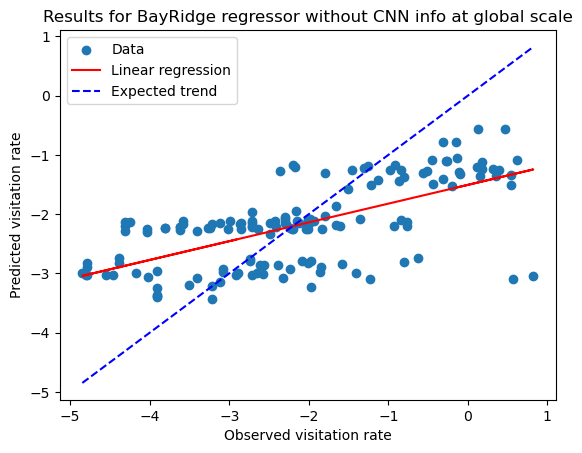

In [28]:
import matplotlib.pyplot as plt
import numpy as np

y_true = y_test.to_numpy()
y_true_array = y_true.flatten()
# fit a regression line with numpy
coef = np.polyfit(y_true_array, y_pred_NO_CNN, 1)
poly1d_fn = np.poly1d(coef)

# create a scatter plot with regression line
plt.scatter(y_true_array, y_pred_NO_CNN, label='Data')
plt.plot(y_true_array, poly1d_fn(y_true_array), color = 'red', label = 'Linear regression')
plt.plot(sorted(y_true_array), sorted(y_true_array), color = 'blue', linestyle = '--', label = 'Expected trend')

# Add labels
plt.xlabel('Observed visitation rate')
plt.ylabel('Predicted visitation rate')
plt.title('Results for BayRidge regressor without CNN info at global scale')

# show legend
plt.legend()

# show plot
plt.show()

bio02: VIP = 10.693305261227938
bio01: VIP = 10.247257957723725
elevation: VIP = 9.059483610344524
management_y: VIP = 8.866089753059512
x0_4.0: VIP = 7.811767706216657
x0_8.0: VIP = 7.238434861033114
x0_7.0: VIP = 5.643140699231828
x0_2.0: VIP = 5.233843488505268
gHM: VIP = 5.21694345652993
moss: VIP = 5.087220601970013
ec: VIP = 3.3852935138876483
bio05: VIP = 3.352149187928019
bio08: VIP = 3.2466914873196644
shrub: VIP = 3.0794163304384012
soil_den_b10: VIP = 2.7863158996839394
x0_10.0: VIP = 2.68723596314538
x0_12.0: VIP = 2.3472454357959704
x0_5.0: VIP = 1.9662856867209186
es: VIP = 1.84949159819454
bio14: VIP = 1.1657482362635085
x0_1.0: VIP = 0.6436651034613913
pdsi: VIP = 0.5475761729234212


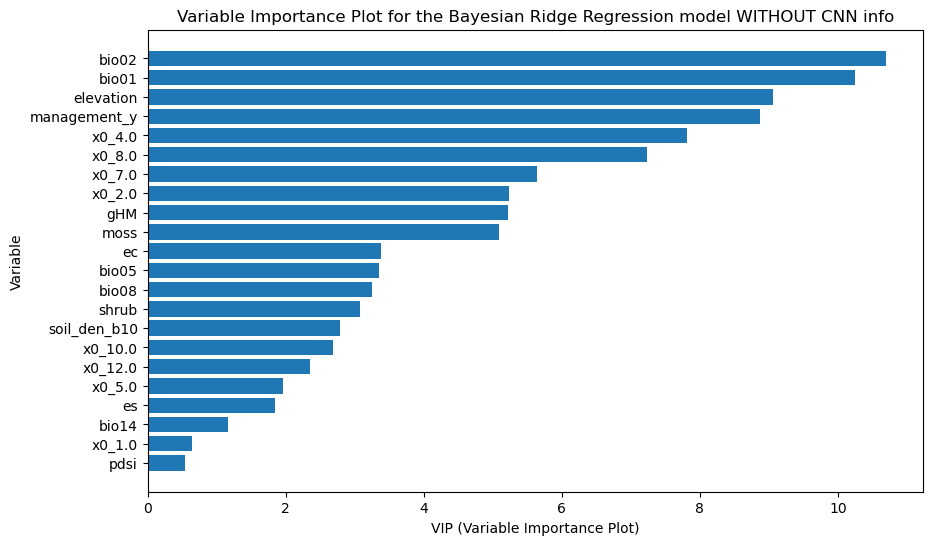

In [29]:
# Get coef. from the best model estimated
coeficients_NO_CNN = best_model_NO_CNN.coef_

# Get variance from the estimated coeficients
variance_coefs_NO_CNN = np.var(coeficients_NO_CNN)

# Estimate VIP for each variable
VIP_NO_CNN = np.abs(coeficients_NO_CNN) / variance_coefs_NO_CNN

# Sort VIP
sorted_indices_NO_CNN = np.argsort(VIP_NO_CNN)[::-1]  # Sort from larger to smaller VIP
sorted_VIP_NO_CNN = VIP_NO_CNN[sorted_indices_NO_CNN]

# Print VIP
for i, idx in enumerate(sorted_indices_NO_CNN):
    print(f"{X_columns_NO_CNN[idx]}: VIP = {sorted_VIP_NO_CNN[i]}")
    
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_indices_NO_CNN)), sorted_VIP_NO_CNN, align='center')
plt.yticks(range(len(sorted_indices_NO_CNN)), [X_columns_NO_CNN[i] for i in sorted_indices_NO_CNN])
plt.xlabel('VIP (Variable Importance Plot)')
plt.ylabel('Variable')
plt.title('Variable Importance Plot for the Bayesian Ridge Regression model WITHOUT CNN info')
plt.gca().invert_yaxis()  # Invertir el eje y para que las variables más importantes estén arriba
plt.show()

In [30]:
# Ajustemos añadiendo los datos del BayReg y el resto de variables del Bayreg+CNN
from sklearn.preprocessing import StandardScaler
import numpy as np

# Ajustemos añadiendo las predicciones del BayReg y el resto de variables del Bayreg+CNN

# Añadir las predicciones de BayReg como nueva columna
X_train_CNN_Bay_others = np.hstack((X_train_CNN, y_pred_train_NO_CNN.reshape(-1, 1)))
X_test_CNN_Bay_others = np.hstack((X_test_CNN, y_pred_test_NO_CNN.reshape(-1, 1)))

# Escalar las características
scaler_CNN_Bay_others = StandardScaler()

# Ajustar y transformar el conjunto de entrenamiento
X_train_CNN_Bay_others = scaler_CNN_Bay_others.fit_transform(X_train_CNN_Bay_others)

# Transformar el conjunto de test
X_test_CNN_Bay_others = scaler_CNN_Bay_others.transform(X_test_CNN_Bay_others)

NameError: name 'y_pred_train_NO_CNN' is not defined

In [ ]:
X_train_CNN.columns

In [298]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Supongamos que tus datos están en un DataFrame de pandas
df = pd.DataFrame(X_train_CNN_Bay_others, columns=[f'var_{i}' for i in range(X_train_CNN_Bay_others.shape[1])])
df['target'] = y_train

# Calcular la matriz de correlación
correlation_matrix_CNN_Bay_others = df.corr()

# Mostrar la matriz de correlación
print(correlation_matrix_CNN_Bay_others)

# Establecer la diagonal de la matriz de correlación a cero
np.fill_diagonal(correlation_matrix_CNN_Bay_others.values, 0)

# Seleccionar características menos correlacionadas
# Aquí utilizamos un umbral arbitrario, por ejemplo, 0.8
threshold = 0.8
# Alta correlación entre biom12 ('var_23') y Bayrig ('var_24')
columns_to_remove = 'var_23' # [column for column in correlation_matrix_CNN_Bay_others.columns if any(abs(correlation_matrix_CNN_Bay_others[column]) > threshold) and column != 'target']
print(columns_to_remove )
X_train_CNN_Bay_others_reduced = df.drop(columns=columns_to_remove).drop(columns='target').values
y_train_CNN_Bay_others_reduced = df['target'].values

print(X_train_CNN_Bay_others_reduced)

           var_0     var_1     var_2     var_3     var_4     var_5     var_6  \
var_0   1.000000 -0.338148  0.173657 -0.072965 -0.033159  0.324798 -0.233877   
var_1  -0.338148  1.000000  0.147886  0.673425  0.573186 -0.292413  0.794919   
var_2   0.173657  0.147886  1.000000  0.607082  0.131923  0.027412 -0.011250   
var_3  -0.072965  0.673425  0.607082  1.000000  0.552101 -0.076629  0.432949   
var_4  -0.033159  0.573186  0.131923  0.552101  1.000000  0.124962  0.488991   
var_5   0.324798 -0.292413  0.027412 -0.076629  0.124962  1.000000 -0.225292   
var_6  -0.233877  0.794919 -0.011250  0.432949  0.488991 -0.225292  1.000000   
var_7  -0.338398  0.307097  0.128287 -0.022731  0.012685 -0.359658  0.454406   
var_8  -0.190801  0.146235  0.403948  0.252862  0.140563 -0.047677 -0.175500   
var_9  -0.047887 -0.565195 -0.462724 -0.581208 -0.434076  0.001855 -0.535267   
var_10 -0.028018  0.068563  0.047998  0.251661  0.308577 -0.073608  0.138103   
var_11  0.194410 -0.307517  0.335003  0.

In [300]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform, randint

# Definir el espacio de hiperparámetros a explorar
param_dist_CNN_Bay_others = {
    'loss': ['ls', 'lad', 'huber', 'quantile'],
    'learning_rate': uniform(loc=0, scale=.1),
    'n_estimators': randint(50, 600),  # Utilizamos randint para valores enteros en un rango
    'subsample': uniform(loc=0, scale=1), #[1],
    'min_samples_split': uniform(loc=0, scale=1),
    'min_samples_leaf': uniform(loc=0, scale=0.5),
    'min_weight_fraction_leaf': uniform(loc=0, scale=0.5),
    'max_depth': [2, 4, 8, 32, 64, 128], #[2, 4, 8, 16, 32],
    'min_impurity_decrease': uniform(loc=0, scale=1),
    'max_features': uniform(loc=0, scale=1),
    'alpha': uniform(loc=0, scale=1),
    'max_leaf_nodes': [8, 16, 32, 64], #[8, 16, 32, 64],
    'ccp_alpha': uniform(loc=0, scale=1)
}
# Crear una instancia del modelo Gradient Boosting
model_CNN_Bay_others_reduced = GradientBoostingRegressor()

# Número de iteraciones aleatorias
n_iter = 25000

# Crear un objeto RandomizedSearchCV para búsqueda aleatoria
random_search_CNN_Bay_others_reduced = RandomizedSearchCV(model_CNN_Bay_others_reduced, param_distributions=param_dist_CNN_Bay_others, cv = myCViterator, scoring='neg_mean_absolute_error', n_iter= n_iter,verbose=2, random_state=135, n_jobs=8)

# Realizar la búsqueda aleatoria en el espacio de hiperparámetros
random_search_CNN_Bay_others_reduced.fit(X_train_CNN_Bay_others_reduced, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params_CNN_Bay_others_reduced = random_search_CNN_Bay_others_reduced.best_params_
print(f"Mejores hiperparámetros: {random_search_CNN_Bay_others_reduced}")

# Obtener el mejor modelo ajustado
best_model_CNN_Bay_others_reduced = random_search_CNN_Bay_others_reduced.best_estimator_

Fitting 5 folds for each of 25000 candidates, totalling 125000 fits


C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
63515 fits failed out of a total of 125000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3926 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\alfon\anaconda3\Lib\site-

C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan ... -1.1803864  -1.18256117
         nan]
  warnings.warn(
C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mejores hiperparámetros: RandomizedSearchCV(cv=[(array([  0,   1,   2,   3,   4,   5,   6,   7,  17,  18,  19,  20,  21,
        22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,
        35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
        48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
        61,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,...
                                        'min_weight_fraction_leaf': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000178D72C7D90>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000178D8313F50>,
                                        'subsample': <scipy.stats._distn_inf

In [301]:
# make predictions
y_pred_CNN_Bay_others = best_model_CNN_Bay_others.predict(X_test_CNN_Bay_others)

# Evaluation of our best model
mae_CNN_Bay_others = mean_absolute_error(y_test, y_pred_CNN_Bay_others)
mse_CNN_Bay_others = mean_squared_error(y_test, y_pred_CNN_Bay_others)
rmse_CNN_Bay_others = np.sqrt(mse_CNN_Bay_others)
r2_CNN_Bay_others = r2_score(y_test, y_pred_CNN_Bay_others)

# Estimate spearman rho
coef_spearman_CNN_Bay_others, p_valor_spearman_CNN_Bay_others = spearmanr(y_test, y_pred_CNN_Bay_others)

# Best model results
# print("Model coefficients:", best_model_NO_CNN.coef_)
# print("Intercept:", best_model_NO_CNN.intercept_)
print("Mean square error (MSE):", mse_CNN_Bay_others)
print("Root mean square error (RMSE):", rmse_CNN_Bay_others)
print("R-squared:", r2_CNN_Bay_others)
print("Mean absolute error (MAE):", mae_CNN_Bay_others)
print("Spearman-rho:", coef_spearman_CNN_Bay_others,"(pvalor:",p_valor_spearman_CNN_Bay_others,")")

Mean square error (MSE): 1.347393737799553
Root mean square error (RMSE): 1.160772905352099
R-squared: 0.34184284730574177
Mean absolute error (MAE): 0.9516245033349482
Spearman-rho: 0.5744280228242412 (pvalor: 1.5213764892672605e-14 )


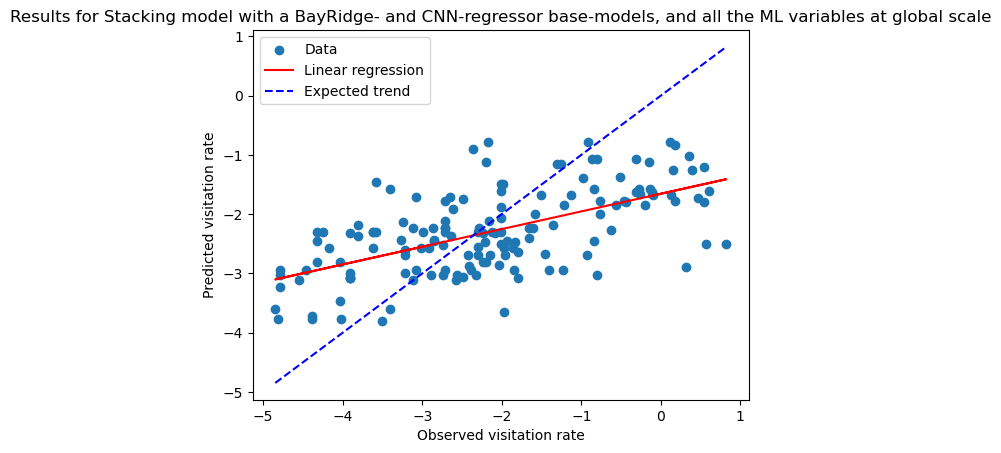

In [302]:
import matplotlib.pyplot as plt
import numpy as np

y_test_1d_CNN_Bay_others = y_test.numpy().flatten() if isinstance(y_test, torch.Tensor) else np.array(y_test).flatten()

# fit a regression line with numpy
coef_CNN_Bay_others = np.polyfit(y_test_1d_CNN_Bay_others, y_pred_CNN_Bay_others, 1)
poly1d_fn_CNN_Bay_others = np.poly1d(coef_CNN_Bay_others)

# create a scatter plot with regression line
plt.scatter(y_test_1d_CNN_Bay_others, y_pred_CNN_Bay_others, label='Data')
plt.plot(y_test_1d_CNN_Bay_others, poly1d_fn_CNN_Bay_others(y_test_1d_CNN_Bay_others), color = 'red', label = 'Linear regression')
plt.plot(sorted(y_test_1d_CNN_Bay_others), sorted(y_test_1d_CNN_Bay_others), color = 'blue', linestyle = '--', label = 'Expected trend')

# Add labels
plt.xlabel('Observed visitation rate')
plt.ylabel('Predicted visitation rate')
plt.title('Results for Stacking model with a BayRidge- and CNN-regressor base-models, and all the ML variables at global scale')

# show legend
plt.legend()

# show plot
plt.show()

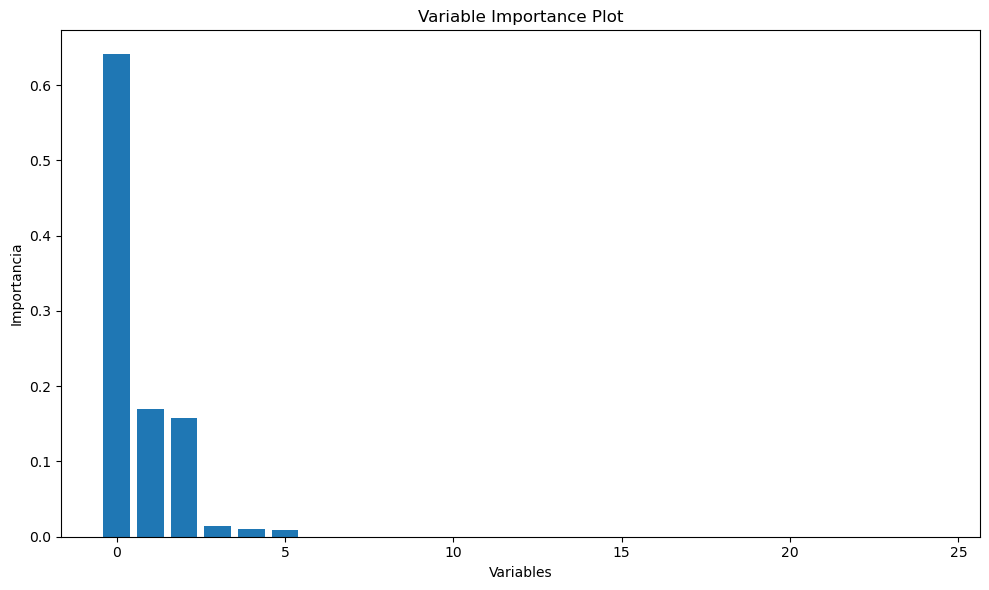

In [303]:
# Paso 2: Obtén la importancia de las variables desde el modelo
feature_importance_CNN_Bay_others = best_model_CNN_Bay_others.feature_importances_

# Paso 3: Crea un gráfico de barras para visualizar la importancia de las variables
# Puedes ordenar las variables por importancia si lo deseas
sorted_idx_CNN_Bay_others = np.argsort(feature_importance_CNN_Bay_others)[::-1]  # Orden descendente

# Obtén los nombres de las características (columnas) si los tienes
feature_names_CNN_Bay_others = list(X_train_CNN.columns)  # Reemplaza con tus nombres de características reales

# Crea el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_idx_CNN_Bay_others)), feature_importance_CNN_Bay_others[sorted_idx_CNN_Bay_others], align='center')
#plt.xticks(range(len(sorted_idx_CNN_Bay_others)), [feature_names_CNN_Bay_others[i] for i in sorted_idx_CNN_Bay_others], rotation=90)
plt.xlabel('Variables')
plt.ylabel('Importancia')
plt.title('Variable Importance Plot')
plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Definir el modelo de la red neuronal con Dropout y L2 Regularization
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Crear el modelo
input_dim = X_train_CNN_Bay_others.shape[1]
model = NeuralNetwork(input_dim)

# Definir el optimizador con L2 Regularization (Weight Decay)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss()

# Convertir los datos a tensores de PyTorch
X_train_tensor = torch.tensor(X_train_CNN_Bay_others, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_CNN_Bay_others, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Crear DataLoader para el entrenamiento
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Dividir el conjunto de entrenamiento para validación temprana (early stopping)
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_tensor, y_train_tensor, test_size=0.2, random_state=42
)

val_dataset = TensorDataset(X_val_split, y_val_split)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Early Stopping
patience = 20
best_loss = float('inf')
trigger_times = 0

num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Validación temprana (early stopping)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}")
    
    if val_loss < best_loss:
        best_loss = val_loss
        trigger_times = 0
        # Guardar el mejor modelo
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print('Early stopping!')
            break

# Cargar el mejor modelo
model.load_state_dict(torch.load('best_model.pth'))

# Evaluar el modelo en el conjunto de test
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor).numpy()

# Calcular el coeficiente de Spearman
rho = spearmanr(y_test, y_pred_test.flatten())[0]
print(f"Spearman's rho en el conjunto de test: {rho:.4f}")


In [315]:
# Probamos a hacer una búsqueda optimizada de parámetros para el neural regressor

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from torch.utils.data import DataLoader, TensorDataset
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV

# Definir el modelo de la red neuronal con Batch Normalization y Dropout
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim1=64, hidden_dim2=32, dropout_rate=0.5):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_dim2, 1)
    
    def forward(self, x):
        x = torch.selu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.selu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Crear un NeuralNetRegressor
net = NeuralNetRegressor(
    NeuralNetwork,
    module__input_dim=X_train_CNN_Bay_others.shape[1],
    max_epochs=50,
    lr=0.01,
    optimizer=optim.Adam,
    iterator_train__shuffle=True,
    device='cuda' if torch.cuda.is_available() else 'cpu',  # Usa GPU si está disponible
)

# Definir la cuadrícula de hiperparámetros
params = {
    'lr': [0.0001, 0.001, 0.01, 0.1],
    'max_epochs': [50, 100, 200, 500, 1000],
    'module__hidden_dim1': [16, 32, 64, 128],
    'module__hidden_dim2': [8, 16, 32, 64],
    'module__dropout_rate': [0.15, 0.3, 0.5, 0.7, 0.9],
}

# Convertir los datos a tensores de PyTorch
X_train_tensor = torch.tensor(X_train_CNN_Bay_others, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_CNN_Bay_others, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Realizar la búsqueda de hiperparámetros con GridSearchCV
gs = GridSearchCV(net, params, refit=True, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
gs.fit(X_train_tensor, y_train_tensor)

# Imprimir los mejores hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(gs.best_params_)

# Evaluar el modelo en el conjunto de test
y_pred_test = gs.predict(X_test_tensor)

# Calcular el coeficiente de Spearman
rho = spearmanr(y_test, y_pred_test.flatten())[0]
print(f"Spearman's rho en el conjunto de test: {rho:.4f}")


Fitting 3 folds for each of 1600 candidates, totalling 4800 fits
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        8.9577        4.5503  0.0260
      2        6.9902        4.3404  0.0290
      3        5.8591        4.1378  0.0290
      4        5.5419        3.8429  0.0250
      5        5.0750        3.4747  0.0270
      6        4.6305        3.0445  0.0260
      7        4.2580        2.6878  0.0280
      8        3.8960        2.2916  0.0280
      9        3.3055        1.9396  0.0260
     10        2.9799        1.6467  0.0330
     11        2.9499        1.4494  0.0320
     12        2.7107        1.3520  0.0330
     13        2.4252        1.3178  0.0320
     14        2.5075        1.2414  0.0300
     15        2.4710        1.2183  0.0420
     16        2.1735        1.2556  0.0260
     17        2.3028        1.2645  0.0260
     18        1.9896        1.1968  0.0310
     19        2.0762        1.1326  0.0300
     20    

In [32]:
# Probamos a hacer una búsqueda optimizada de parámetros para el neural regressor

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from torch.utils.data import DataLoader, TensorDataset
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV

# Definir el modelo de la red neuronal con Batch Normalization y Dropout
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim1=64, hidden_dim2=32, dropout_rate=0.5):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_dim2, 1)
    
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Crear un NeuralNetRegressor
net = NeuralNetRegressor(
    NeuralNetwork,
    module__input_dim=X_train_CNN_Bay_others.shape[1],
    max_epochs=50,
    lr=0.01,
    optimizer=optim.Adam,
    iterator_train__shuffle=True,
    device='cuda' if torch.cuda.is_available() else 'cpu',  # Usa GPU si está disponible
)

# Definir la cuadrícula de hiperparámetros
params = {
    'lr': [0.1],
    'max_epochs': [50],
    'module__hidden_dim1': [32],
    'module__hidden_dim2': [32],
    'module__dropout_rate': [.68,.685,.689,.69,.691,.7],
}

# Convertir los datos a tensores de PyTorch
X_train_tensor = torch.tensor(X_train_CNN_Bay_others, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_CNN_Bay_others, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Realizar la búsqueda de hiperparámetros con GridSearchCV
gs = GridSearchCV(net, params, refit=True, cv=myCViterator, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
gs.fit(X_train_tensor, y_train_tensor)

# Imprimir los mejores hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(gs.best_params_)

# Evaluar el modelo en el conjunto de test
y_pred_test = gs.predict(X_test_tensor)

# Calcular el coeficiente de Spearman
rho = spearmanr(y_test, y_pred_test.flatten())[0]
print(f"Spearman's rho en el conjunto de test: {rho:.4f}")

NameError: name 'X_train_CNN_Bay_others' is not defined

In [332]:
# Guardar los mejores hiperparámetros y el modelo entrenado
best_model = gs.best_estimator_.module_
# torch.save(best_model.state_dict(), 'best_model.pth') #Comentado por seguridad

In [316]:
#Mejores hiperparámetros encontrados (ReLu, grid completa, cv=3):
#{'lr': 0.1, 'max_epochs': 50, 'module__dropout_rate': 0.7, 'module__hidden_dim1': 32, 'module__hidden_dim2': 32}
#Spearman's rho en el conjunto de test: 0.6270
# Muy cerca del BayRidgdge (0.63)

#Mejores hiperparámetros encontrados (SeLu, grid completa, cv=3):
#{'lr': 0.01, 'max_epochs': 50, 'module__dropout_rate': 0.9, 'module__hidden_dim1': 128, 'module__hidden_dim2': 64}
#Spearman's rho en el conjunto de test: 0.5036

#Mejores hiperparámetros encontrados(SeLu, grid parcial, cv=3):
#{'lr': 0.1, 'max_epochs': 50, 'module__dropout_rate': 0.7, 'module__hidden_dim1': 16, 'module__hidden_dim2': 32}
#Spearman's rho en el conjunto de test: 0.5219

#Mejores hiperparámetros encontrados(ReLu, grid parcial, cv=3):
#{'lr': 0.1, 'max_epochs': 50, 'module__dropout_rate': 0.69, 'module__hidden_dim1': 32, 'module__hidden_dim2': 32}
#Spearman's rho en el conjunto de test: 0.6320

#Mejores hiperparámetros encontrados(ReLu, grid parcial, cv=my_cviterator):
#{'lr': 0.1, 'max_epochs': 50, 'module__dropout_rate': 0.68, 'module__hidden_dim1': 32, 'module__hidden_dim2': 32}
#Spearman's rho en el conjunto de test: 0.6464

In [334]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr, spearmanr

# Evaluar el modelo en el conjunto de test
y_pred_test = gs.predict(X_test_tensor)

# Convertir y_test a NumPy
y_test_numpy = y_test_tensor.numpy()

# Calcular R^2
r2 = r2_score(y_test_numpy, y_pred_test)
print(f'R^2 Score: {r2}')

# Calcular MSE
mse_loss = mean_squared_error(y_test_numpy, y_pred_test)
print("MSE:", mse_loss)

# Calcular RMSE
rmse_loss = np.sqrt(mse_loss)
print("RMSE:", rmse_loss)

# Calcular MAE
mae_loss = mean_absolute_error(y_test_numpy, y_pred_test)
print("MAE:", mae_loss)

# Aplanar y_test para que tenga una sola dimensión
y_test_flat = y_test_numpy.flatten()

# Calcular Pearson's r
corr, p_value_r = pearsonr(y_test_flat, y_pred_test.flatten())
print("Pearson's r:", corr)
print("p-value (Pearson):", p_value_r)

# Calcular Spearman's rho
rho, p_value_rho = spearmanr(y_test_flat, y_pred_test.flatten())
print("Spearman's rho:", rho)
print("p-value (Spearman):", p_value_rho)

R^2 Score: 0.2211582776388331
MSE: 1.5944618
RMSE: 1.26272
MAE: 1.0370429
Pearson's r: 0.5991909772454027
p-value (Pearson): 5.488876945038092e-16
Spearman's rho: 0.6463500157826148
p-value (Spearman): 4.1567265559318985e-19


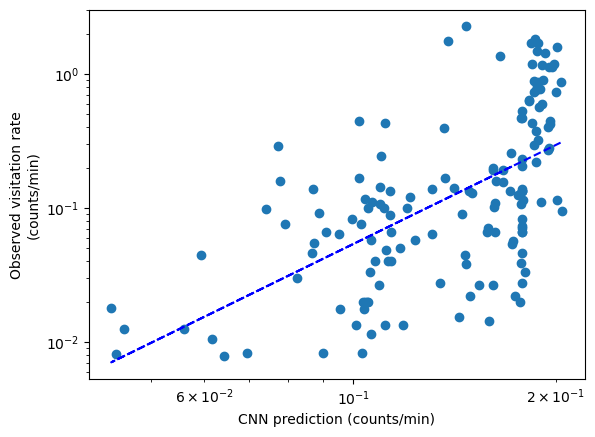

In [335]:
import matplotlib.pyplot as plt
import numpy as np

# Convertir y_test a NumPy
y_test_numpy = y_test_tensor.numpy()

# Exponenciar los valores de los puntos
y_test_1d = y_test_numpy.flatten()
y_test_1d_exp = np.exp(y_test_1d)
y_pred_test_exp = np.exp(y_pred_test.flatten())

# Ajustar una línea de regresión con numpy en la escala exponencial
coef = np.polyfit(np.log10(y_pred_test_exp), np.log10(y_test_1d_exp), 1)
poly1d_fn = np.poly1d(coef)

# Crear una gráfica de dispersión con la línea de regresión
plt.scatter(y_pred_test_exp, y_test_1d_exp)
plt.plot(y_pred_test_exp, 10**poly1d_fn(np.log10(y_pred_test_exp)), color='blue', linestyle='--')

# Configurar los ejes en escala logarítmica en base diez
plt.xscale('log')
plt.yscale('log')

# Añadir etiquetas a los ejes
plt.xlabel('CNN prediction (counts/min)')
plt.ylabel('Observed visitation rate\n(counts/min)')

# Guardar la imagen
plt.savefig('ensemble_scatter_plot_log_scale.png', dpi=300, bbox_inches='tight')

# Mostrar la gráfica
plt.show()

In [374]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Evaluar el modelo en el conjunto de test
loaded_model.eval()

# Obtener los pesos de la primera capa
first_layer_weights = gs.fc1.weight.data.cpu().numpy()

# Calcular la importancia de las características como la suma de los valores absolutos de los pesos
feature_importance = np.sum(np.abs(first_layer_weights), axis=0)

# Normalizar la importancia de las características
feature_importance = feature_importance / np.sum(feature_importance)

# Obtener los nombres de las características (si los tienes)
feature_names = [f'Feature {i}' for i in range(len(feature_importance))]

# Crear el gráfico de barras para la importancia de las características
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance, align='center')
plt.xticks(range(len(feature_importance)), feature_names, rotation=90)
plt.xlabel('Variables')
plt.ylabel('Importancia')
plt.title('Variable Importance Plot (VIP) para la Red Neuronal')
plt.tight_layout()

# Guardar la imagen
plt.savefig('nn_vip_plot.png', dpi=300, bbox_inches='tight')

# Mostrar la gráfica
plt.show()

AttributeError: 'GridSearchCV' object has no attribute 'fc1'

In [370]:
from scipy.stats import uniform

# Generar 10 valores con uniform(0.650, 0.700)
random_values = uniform(loc=0.9, scale=0.2).rvs(10)
print(random_values)

[0.9866619  0.91662557 1.06333981 1.07275276 1.02831156 1.06003068
 1.0550048  0.91863481 0.94598385 1.08705489]


In [372]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr, uniform
from torch.utils.data import DataLoader, TensorDataset
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


# Definir el modelo de la red neuronal con Batch Normalization, Dropout, y más capas
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim1=64, hidden_dim2=32, hidden_dim3=16, dropout_rate1=0.5, dropout_rate2=0.5):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.dropout1 = nn.Dropout(dropout_rate1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.dropout2 = nn.Dropout(dropout_rate2)
        self.fc3 = nn.Linear(hidden_dim2, 1)
    
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Crear un NeuralNetRegressor
net_complex = NeuralNetRegressor(
    NeuralNetwork,
    module__input_dim=X_train_CNN_Bay_others.shape[1],
    max_epochs=50,
    lr=0.01,
    optimizer=optim.Adam,
    iterator_train__shuffle=True,
    device='cuda' if torch.cuda.is_available() else 'cpu',  # Usa GPU si está disponible
)

# Definir la cuadrícula de hiperparámetros
params_complex = {
    'lr': uniform(loc=0.9, scale=0.2),
    'max_epochs': [50],
    'module__hidden_dim1': [32],
    'module__hidden_dim2': [32],
    'module__dropout_rate1': uniform(loc=0.650, scale=0.005),  # Varia entre 0.5 y 1
    'module__dropout_rate2': uniform(loc=0.650, scale=0.005)#uniform(0.650, 0.700)#uniform(0.5, 0.5)  # Varia entre 0.5 y 1
}



#Mejores hiperparámetros encontrados(ReLu, grid parcial, cv=my_cviterator):
#{'lr': 0.1, 'max_epochs': 50, 'module__dropout_rate': 0.68, 'module__hidden_dim1': 32, 'module__hidden_dim2': 32}
#Spearman's rho en el conjunto de test: 0.6464

# Convertir los datos a tensores de PyTorch
X_train_tensor = torch.tensor(X_train_CNN_Bay_others, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_CNN_Bay_others, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Realizar la búsqueda de hiperparámetros con GridSearchCV
gs_complex = RandomizedSearchCV(net_complex, params_complex, refit=True, cv=myCViterator, 
                                scoring='neg_mean_squared_error', n_iter=2000, verbose=2, n_jobs=-1)
gs_complex.fit(X_train_tensor, y_train_tensor)

# Imprimir los mejores hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(gs_complex.best_params_)

# Evaluar el modelo en el conjunto de test
y_pred_test_complex = gs_complex.predict(X_test_tensor)

# Calcular el coeficiente de Spearman
rho = spearmanr(y_test, y_pred_test_complex.flatten())[0]
print(f"Spearman's rho en el conjunto de test: {rho:.4f}")

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       76.6861      254.7872  0.0200
      2       12.3205       25.7834  0.0200
      3        7.4872        8.9984  0.0250
      4        5.4780        3.3723  0.0190
      5        3.4921        4.3179  0.0230
      6        2.8682        3.1421  0.0210
      7        4.2673        2.2022  0.0210
      8        2.1635        2.0830  0.0270
      9        2.2335        2.1077  0.0200
     10        2.0657        2.3073  0.0210
     11        2.0446        2.5155  0.0220
     12        2.4213        2.4158  0.0220
     13        2.0254        2.2688  0.0240
     14        2.0443        2.2013  0.0270
     15        2.0356        2.2667  0.0340
     16        2.6543        2.2868  0.0280
     17        2.0225        2.3127  0.0220
     18        2.0275        2.3289  0.0220
     19        2.0271        2.2714  0.0210
     20   

In [376]:
gs_complex.predict(X_test_tensor)

array([[-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.2704535],
       [-2.27

In [375]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr, spearmanr

# Evaluar el modelo en el conjunto de test
y_pred_test_complex = gs_complex.predict(X_test_tensor)

# Convertir y_test a NumPy
y_test_numpy = y_test_tensor.numpy()

# Calcular R^2
r2_complex = r2_score(y_test_numpy, y_pred_test_complex)
print(f'R^2 Score: {r2}')

# Calcular MSE
mse_loss_complex = mean_squared_error(y_test_numpy, y_pred_test_complex)
print("MSE:", mse_loss_complex)

# Calcular RMSE
rmse_loss_complex = np.sqrt(mse_loss_complex)
print("RMSE:", rmse_loss_complex)

# Calcular MAE
mae_loss_complex = mean_absolute_error(y_test_numpy, y_pred_test_complex)
print("MAE:", mae_loss_complex)

# Aplanar y_test para que tenga una sola dimensión
y_test_flat_complex = y_test_numpy.flatten()

# Calcular Pearson's r
corr_complex, p_value_r_complex = pearsonr(y_test_flat_complex, y_pred_test_complex.flatten())
print("Pearson's r:", corr_complex)
print("p-value (Pearson):", p_value_r_complex)

# Calcular Spearman's rho
rho_complex, p_value_rho_complex = spearmanr(y_test_flat_complex, y_pred_test_complex.flatten())
print("Spearman's rho:", rho_complex)
print("p-value (Spearman):", p_value_rho_complex)

R^2 Score: 0.2211582776388331
MSE: 2.0637546
RMSE: 1.4365773
MAE: 1.1562551
Pearson's r: nan
p-value (Pearson): nan
Spearman's rho: nan
p-value (Spearman): nan


C:\Users\alfon\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\alfon\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [31]:
y_pred_test_NO_CNN = best_model_NO_CNN.predict(X_test_NO_CNN)
df_ML_test_without_na['BayReg'] = y_pred_test_NO_CNN.flatten()

y_pred_train_NO_CNN = best_model_NO_CNN.predict(X_train_NO_CNN)
df_ML_train_without_na['BayReg'] = y_pred_train_NO_CNN.flatten()

C:\Users\alfon\AppData\Local\Temp\ipykernel_24916\2256980901.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ML_test_without_na['BayReg'] = y_pred_test_NO_CNN.flatten()
C:\Users\alfon\AppData\Local\Temp\ipykernel_24916\2256980901.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ML_train_without_na['BayReg'] = y_pred_train_NO_CNN.flatten()


In [274]:
df_ML_train_without_na.columns

Index(['study_id', 'site_id', 'crop', 'biome_num', 'management_x',
       'sampling_year', 'log_vr_large', 'log_vr_small', 'plot_id',
       'log_vr_total', 'global_regressor_V0', 'bio01', 'bio02', 'bio05',
       'bio08', 'bio14', 'ec', 'elevation', 'es', 'gHM', 'pdsi',
       'soil_den_b10', 'moss', 'shrub', 'management_y', 'x0_1.0', 'x0_2.0',
       'x0_4.0', 'x0_5.0', 'x0_7.0', 'x0_8.0', 'x0_10.0', 'x0_12.0', 'BayReg'],
      dtype='object')

In [167]:
X_columns_stack = ['global_regressor_V0','BayReg']
y_columns = ['log_vr_total']

X_train_stack = df_ML_train_without_na[X_columns_stack]
X_test_stack = df_ML_test_without_na[X_columns_stack]


# Escalar las columnas seleccionadas
columnas_a_escalar_stack = ['global_regressor_V0','BayReg']

# Crear una instancia de StandardScaler
scaler_Bay_CNN = StandardScaler()

# Escalar las columnas seleccionadas para los datos de entrenamiento
X_train_stack[columnas_a_escalar_stack] = scaler_Bay_CNN.fit_transform(X_train_stack[columnas_a_escalar_stack])

# Aplicar la transformación a los datos de prueba con el mismo scaler
X_test_stack[columnas_a_escalar_stack] = scaler_Bay_CNN.transform(X_test_stack[columnas_a_escalar_stack])


y_train = df_ML_train_without_na[y_columns]
y_test = df_ML_test_without_na[y_columns]

C:\Users\alfon\AppData\Local\Temp\ipykernel_21784\4269234691.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_stack[columnas_a_escalar_stack] = scaler_Bay_CNN.fit_transform(X_train_stack[columnas_a_escalar_stack])
C:\Users\alfon\AppData\Local\Temp\ipykernel_21784\4269234691.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_stack[columnas_a_escalar_stack] = scaler_Bay_CNN.transform(X_test_stack[columnas_a_escalar_stack])


In [175]:
import pandas as pd

# Calcular la matriz de correlación de Spearman
correlation_matrix_spearman = df_ML_train_without_na[['global_regressor_V0', 'BayReg']].corr(method='spearman')
print("Matriz de correlación de Spearman:")
print(correlation_matrix_spearman)

# Calcular la matriz de correlación de Pearson
correlation_matrix_pearson = df_ML_train_without_na[['global_regressor_V0', 'BayReg']].corr(method='pearson')
print("Matriz de correlación de Pearson:")
print(correlation_matrix_pearson)

Matriz de correlación de Spearman:
                     global_regressor_V0    BayReg
global_regressor_V0             1.000000  0.620968
BayReg                          0.620968  1.000000
Matriz de correlación de Pearson:
                     global_regressor_V0   BayReg
global_regressor_V0              1.00000  0.60199
BayReg                           0.60199  1.00000


In [168]:
# Create a NN para hacer stacking en pytorch
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convertir los conjuntos de datos a tensores de PyTorch
X_train_meta = torch.tensor(X_train_stack.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
X_test_meta = torch.tensor(X_test_stack.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

# Crear datasets y DataLoader para entrenamiento y evaluación
train_dataset = TensorDataset(X_train_meta, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_meta, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [171]:
import torch.nn as nn
import torch.nn.functional as F

# Definición del modelo con 3 capas conectadas
class StackingModel(nn.Module):
    def __init__(self):
        super(StackingModel, self).__init__()
        self.fc1 = nn.Linear(X_train_meta.shape[1], 64)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(32, 16)  # Nueva capa
        self.dropout3 = nn.Dropout(0.5)  # Nuevo dropout
        self.fc4 = nn.Linear(16, 1)  # Capa de salida actualizada
    
    def forward(self, x):
        x = F.selu(self.fc1(x))
        x = self.dropout1(x)
        x = F.selu(self.fc2(x))
        x = self.dropout2(x)
        x = F.selu(self.fc3(x))  # Activación de la nueva capa
        x = self.dropout3(x)  # Aplicación del nuevo dropout
        x = self.fc4(x)  # Capa de salida actualizada
        return x

model = StackingModel()

In [172]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
criterion = nn.MSELoss()

# Bucle de entrenamiento
num_epochs = 2000
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets.view(-1, 1))
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 10, Loss: 8.638345718383789
Epoch 20, Loss: 3.57558274269104
Epoch 30, Loss: 7.5519866943359375
Epoch 40, Loss: 4.14354133605957
Epoch 50, Loss: 5.853842258453369
Epoch 60, Loss: 4.54661226272583
Epoch 70, Loss: 2.466198682785034
Epoch 80, Loss: 3.7331695556640625
Epoch 90, Loss: 4.634888648986816
Epoch 100, Loss: 3.7578651905059814
Epoch 110, Loss: 2.9371438026428223
Epoch 120, Loss: 2.243992805480957
Epoch 130, Loss: 2.225698232650757
Epoch 140, Loss: 2.376061201095581
Epoch 150, Loss: 1.515581488609314
Epoch 160, Loss: 1.555614948272705
Epoch 170, Loss: 2.143510103225708
Epoch 180, Loss: 2.695410966873169
Epoch 190, Loss: 2.2778749465942383
Epoch 200, Loss: 2.5155789852142334
Epoch 210, Loss: 2.2890357971191406
Epoch 220, Loss: 1.3604509830474854
Epoch 230, Loss: 2.996399164199829
Epoch 240, Loss: 3.159966230392456
Epoch 250, Loss: 2.9164931774139404
Epoch 260, Loss: 1.5482274293899536
Epoch 270, Loss: 1.1705262660980225
Epoch 280, Loss: 1.2567826509475708
Epoch 290, Loss: 2.1

In [173]:
import torch
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import spearmanr, pearsonr

model.eval()
with torch.no_grad():
    y_pred = []
    for data, targets in test_loader:
        outputs = model(data)
        y_pred.extend(outputs.numpy().flatten())

# Usa sklearn.metrics para calcular métricas adicionales, como R^2
print(f'R^2 Score: {r2_score(y_test.numpy(), y_pred)}')

# Calcular MSE
mse_loss = mean_squared_error(y_test.numpy(), y_pred)
print("MSE:", mse_loss)

# Calcular RMSE
rmse_loss = np.sqrt(mse_loss)
print("RMSE:", rmse_loss)

# Calcular MAE
mae_loss = mean_absolute_error(y_test.numpy(), y_pred)
print("MAE:", mae_loss)

# Calcular R^2
r2 = r2_score(y_test.numpy(), y_pred)
print("R^2:", r2)

# Aplanar y_test para que tenga una sola dimensión
y_test_flat = y_test.numpy().flatten()


# Calcular Pearson's r
corr, p_value_r = pearsonr(y_test_flat, y_pred)
print("Pearson's r:", corr)
print("p-value (Pearson):", p_value_r)

# Calcular Spearman's rho
rho, p_value_rho = spearmanr(y_test_flat, y_pred)
print("Spearman's rho:", rho)
print("p-value (Spearman):", p_value_rho)

R^2 Score: 0.27827278412295564
MSE: 1.4775358
RMSE: 1.2155393
MAE: 0.98116964
R^2: 0.27827278412295564
Pearson's r: 0.5331598163591824
p-value (Pearson): 2.15837147081381e-12
Spearman's rho: 0.5600325063762932
p-value (Spearman): 9.263025971166186e-14


In [100]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform, randint

# Definir el espacio de hiperparámetros a explorar
param_dist = {
    'loss': ['huber'],#['ls', 'lad', 'huber', 'quantile'],
    'learning_rate': uniform(loc=0, scale=.1),
    'n_estimators': randint(50, 600),  # Utilizamos randint para valores enteros en un rango
    'subsample': uniform(loc=0, scale=1), #[1],
    'min_samples_split': uniform(loc=0, scale=1),
    'min_samples_leaf': uniform(loc=0, scale=0.5),
    'min_weight_fraction_leaf': uniform(loc=0, scale=0.5),
    'max_depth': [2, 4, 8, 32, 64, 128], #[2, 4, 8, 16, 32],
    'min_impurity_decrease': uniform(loc=0, scale=1),
    'max_features': uniform(loc=0, scale=1),
    'alpha': uniform(loc=0, scale=1),
    'max_leaf_nodes': [8, 16, 32, 64], #[8, 16, 32, 64],
    'ccp_alpha': uniform(loc=0, scale=1)
}
# Crear una instancia del modelo Gradient Boosting
model = GradientBoostingRegressor()

# Número de iteraciones aleatorias
n_iter = 25000

# Crear un objeto RandomizedSearchCV para búsqueda aleatoria
random_search_stack = RandomizedSearchCV(model, param_distributions=param_dist, cv = myCViterator, scoring='neg_mean_absolute_error', n_iter= n_iter,verbose=2, random_state=135, n_jobs=8)

# Realizar la búsqueda aleatoria en el espacio de hiperparámetros
random_search_stack.fit(X_train_stack, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params_stack = random_search_stack.best_params_
print(f"Mejores hiperparámetros: {random_search_stack}")

# Obtener el mejor modelo ajustado
best_model_stack = random_search_stack.best_estimator_


Fitting 5 folds for each of 25000 candidates, totalling 125000 fits


C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mejores hiperparámetros: RandomizedSearchCV(cv=[(array([  0,   1,   2,   3,   4,   5,   6,   7,  17,  18,  19,  20,  21,
        22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,
        35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
        48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
        61,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,...
                                        'min_weight_fraction_leaf': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000178F59CC150>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000178AAF44950>,
                                        'subsample': <scipy.stats._distn_inf

In [101]:
best_model_stack

GradientBoostingRegressor(alpha=0.6587067783436116,
                          ccp_alpha=0.027867227536601313,
                          learning_rate=0.05312234099081118, loss='huber',
                          max_depth=32, max_features=0.17818757241202832,
                          max_leaf_nodes=8,
                          min_impurity_decrease=0.11007773986970448,
                          min_samples_leaf=0.012800219640732247,
                          min_samples_split=0.1256645728743203,
                          min_weight_fraction_leaf=0.027557304639759694,
                          n_estimators=355, subsample=0.16048391814894347)

In [102]:
# make predictions
y_pred_stack = best_model_stack.predict(X_test_stack)

# Evaluation of our best model
mae_stack = mean_absolute_error(y_test, y_pred_stack)
mse_stack = mean_squared_error(y_test, y_pred_stack)
rmse_stack = np.sqrt(mse_stack)
r2_stack = r2_score(y_test, y_pred_stack)

# Estimate spearman rho
coef_spearman_stack, p_valor_spearman_stack = spearmanr(y_test, y_pred_stack)

# Best model results
# print("Model coefficients:", best_model_NO_CNN.coef_)
# print("Intercept:", best_model_NO_CNN.intercept_)
print("Mean square error (MSE):", mse_stack)
print("Root mean square error (RMSE):", rmse_stack)
print("R-squared:", r2_stack)
print("Mean absolute error (MAE):", mae_stack)
print("Spearman-rho:", coef_spearman_stack,"(pvalor:",p_valor_spearman_stack,")")

Mean square error (MSE): 1.2938260750243058
Root mean square error (RMSE): 1.1374647577064996
R-squared: 0.3680088876476685
Mean absolute error (MAE): 0.9281561566882097
Spearman-rho: 0.5828678332938857 (pvalor: 5.060629074076534e-15 )


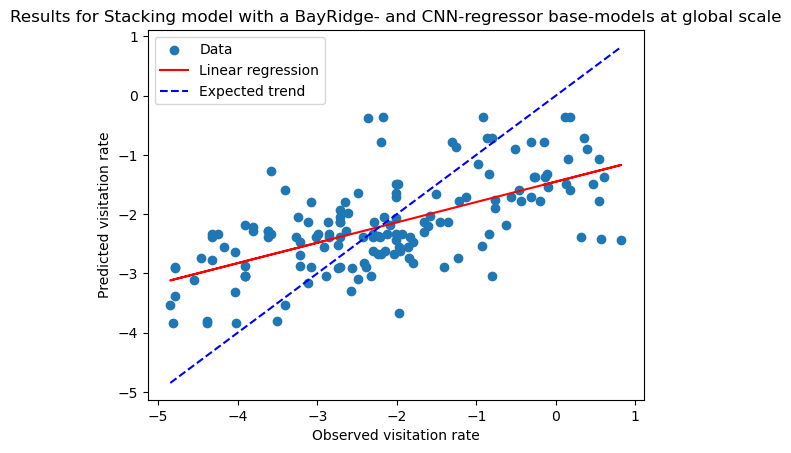

In [54]:
import matplotlib.pyplot as plt
import numpy as np

y_test_1d = y_test.numpy().flatten() if isinstance(y_test, torch.Tensor) else np.array(y_test).flatten()

# fit a regression line with numpy
coef = np.polyfit(y_test_1d, y_pred_stack, 1)
poly1d_fn = np.poly1d(coef)

# create a scatter plot with regression line
plt.scatter(y_test_1d, y_pred_stack, label='Data')
plt.plot(y_test_1d, poly1d_fn(y_test_1d), color = 'red', label = 'Linear regression')
plt.plot(sorted(y_test_1d), sorted(y_test_1d), color = 'blue', linestyle = '--', label = 'Expected trend')

# Add labels
plt.xlabel('Observed visitation rate')
plt.ylabel('Predicted visitation rate')
plt.title('Results for Stacking model with a BayRidge- and CNN-regressor base-models at global scale')

# show legend
plt.legend()

# show plot
plt.show()

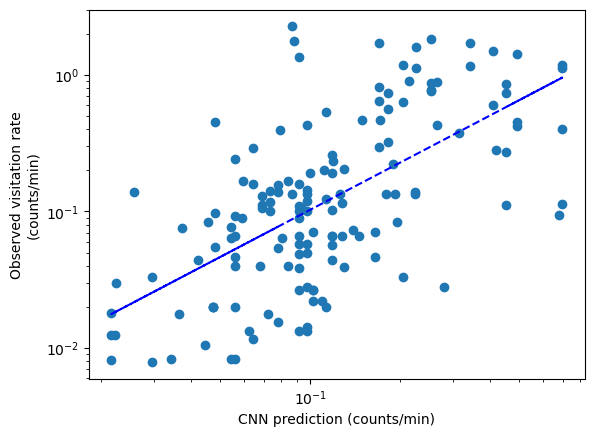

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Exponenciar los valores de los puntos
y_test_1d = y_test.numpy().flatten() if isinstance(y_test, torch.Tensor) else np.array(y_test).flatten()
y_test_1d_exp = np.exp(y_test_1d)
y_pred_stack_exp = np.exp(y_pred_stack)

# Ajustar una línea de regresión con numpy en la escala exponencial
coef = np.polyfit(np.log10(y_pred_stack_exp), np.log10(y_test_1d_exp), 1)
poly1d_fn = np.poly1d(coef)

# Crear una gráfica de dispersión con la línea de regresión
plt.scatter(y_pred_stack_exp, y_test_1d_exp)
plt.plot(y_pred_stack_exp, 10**poly1d_fn(np.log10(y_pred_stack_exp)), color='blue', linestyle='--')

# Configurar los ejes en escala logarítmica en base diez
plt.xscale('log')
plt.yscale('log')

# Añadir etiquetas a los ejes
plt.xlabel('CNN prediction (counts/min)')
plt.ylabel('Observed visitation rate\n(counts/min)')


# Guardar la imagen
plt.savefig('../Figures/ensemble_scatter_plot_log_scale.png', dpi=300, bbox_inches='tight')

# Mostrar la gráfica
plt.show()

In [56]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, spearmanr

# Exponenciar los valores de los puntos
y_test_1d = y_test.numpy().flatten() if isinstance(y_test, torch.Tensor) else np.array(y_test).flatten()
y_test_1d_exp = np.exp(y_test_1d)
y_pred_stack_exp = np.exp(y_pred_stack)

# Calcular el coeficiente de correlación de Pearson
pearson_corr, _ = pearsonr(y_pred_stack_exp, y_test_1d_exp)
print(f"Pearson correlation coefficient: {pearson_corr}")

# Calcular el coeficiente rho de Spearman
spearman_corr, _ = spearmanr(y_pred_stack_exp, y_test_1d_exp)
print(f"Spearman rho: {spearman_corr}")

Pearson correlation coefficient: 0.4227304220490751
Spearman rho: 0.6066856155760478


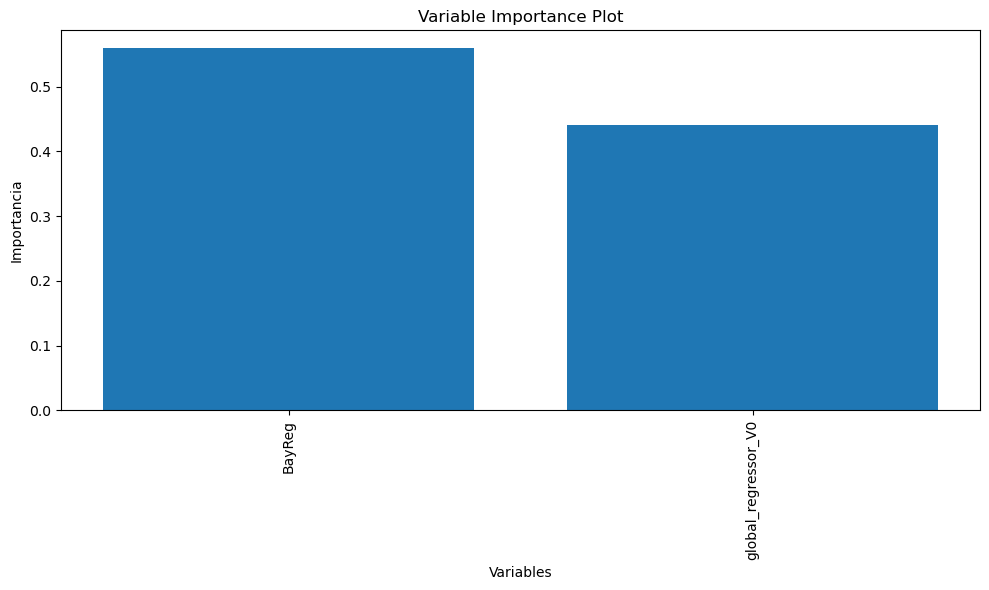

In [131]:
# Paso 2: Obtén la importancia de las variables desde el modelo
feature_importance_stack = best_model_stack.feature_importances_

# Paso 3: Crea un gráfico de barras para visualizar la importancia de las variables
# Puedes ordenar las variables por importancia si lo deseas
sorted_idx_stack = np.argsort(feature_importance_stack)[::-1]  # Orden descendente

# Obtén los nombres de las características (columnas) si los tienes
feature_names_stack = list(X_train_stack.columns)  # Reemplaza con tus nombres de características reales

# Crea el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_idx_stack)), feature_importance_stack[sorted_idx_stack], align='center')
plt.xticks(range(len(sorted_idx_stack)), [feature_names_stack[i] for i in sorted_idx_stack], rotation=90)
plt.xlabel('Variables')
plt.ylabel('Importancia')
plt.title('Variable Importance Plot')
plt.tight_layout()
plt.show()

In [185]:
from scipy.optimize import minimize
from scipy.stats import spearmanr
import numpy as np

# Predicciones de los modelos base
predictions_v0_train = best_model_CNN.predict(X_train_CNN)
predictions_bayreg_train = best_model_NO_CNN.predict(X_train_NO_CNN)
predictions_v0_test = best_model_CNN.predict(X_test_CNN)
predictions_bayreg_test = best_model_NO_CNN.predict(X_test_NO_CNN)


# Definir la función objetivo para minimizar (1 - correlación de Spearman)
def objective(weights):
    # Calcular la combinación de predicciones con los pesos dados
    combined_predictions = weights[0] * predictions_v0_train + weights[1] * predictions_bayreg_train
    # Calcular la correlación de Spearman negativa (porque queremos maximizar la correlación)
    correlation = spearmanr(y_train, combined_predictions)[0]
    return -correlation

# Definir las restricciones: los pesos deben sumar 1
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Definir los límites: los pesos deben estar entre 0 y 1
bounds = [(0, 1), (0, 1)]

# Inicializar los pesos
initial_weights = [0.5, 0.5]

# Optimizar los pesos
result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

# Obtener los pesos optimizados
optimized_weights = result.x
print(f'Pesos optimizados: {optimized_weights}')

# Calcular las predicciones combinadas en el conjunto de entrenamiento y prueba usando los pesos optimizados
train_combined_optimized = optimized_weights[0] * predictions_v0_train + optimized_weights[1] * predictions_bayreg_train
test_combined_optimized = optimized_weights[0] * predictions_v0_test + optimized_weights[1] * predictions_bayreg_test

# Evaluar la correlación de Spearman
spearman_correlation_train_optimized = spearmanr(y_train, train_combined_optimized)
spearman_correlation_test_optimized = spearmanr(y_test, test_combined_optimized)

print(f'Spearman Correlation on Training Set (Optimized): {spearman_correlation_train_optimized}')
print(f'Spearman Correlation on Test Set (Optimized): {spearman_correlation_test_optimized}')

Pesos optimizados: [0.5 0.5]
Spearman Correlation on Training Set (Optimized): SignificanceResult(statistic=0.6854922839769275, pvalue=1.0327603556427729e-110)
Spearman Correlation on Test Set (Optimized): SignificanceResult(statistic=0.6066211285329869, pvalue=1.9139550840232776e-16)


In [188]:
import numpy as np
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from scipy.stats import spearmanr

# Convertir tensores a arrays de NumPy
y_train_np = y_train.numpy().ravel()
y_test_np = y_test.numpy().ravel()

# Definir los modelos base
estimators = [
    ('global_regressor_V0', best_model_CNN),
    ('BayReg', best_model_NO_CNN)
]

# Definir el modelo meta
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=RidgeCV()
)

# Entrenar el modelo de stacking
stacking_model.fit(X_train_stack, y_train_np)

# Evaluar el modelo de stacking en el conjunto de prueba
y_pred_stacking = stacking_model.predict(X_test_stack)
spearman_correlation_stacking = spearmanr(y_test_np, y_pred_stacking)
print(f'Spearman Correlation of Stacking Model: {spearman_correlation_stacking}')

Spearman Correlation of Stacking Model: SignificanceResult(statistic=0.5360803145942606, pvalue=1.553585435535706e-12)


C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\linear_model\_bayes.py:53: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.3 and will be removed in 1.5
  warnings.warn(
C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\linear_model\_bayes.py:53: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.3 and will be removed in 1.5
  warnings.warn(
C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\linear_model\_bayes.py:53: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.3 and will be removed in 1.5
  warnings.warn(
C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\linear_model\_bayes.py:53: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.3 and will be removed in 1.5
  warnings.warn(
C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\linear_model\_bayes.py:53: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.3 and will be removed in 1.5
  warnings.warn(
C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\linear_model\_

In [189]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor

# Definir los modelos base
estimators = [
    ('global_regressor_V0', best_model_CNN),
    ('BayReg', best_model_NO_CNN)
]

# Definir el modelo meta inicial
final_estimator = GradientBoostingRegressor()

# Crear el StackingRegressor
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=final_estimator
)

# Definir el espacio de hiperparámetros para el modelo meta
param_grid = {
    'final_estimator__n_estimators': [100, 200, 300],
    'final_estimator__learning_rate': [0.01, 0.05, 0.1],
    'final_estimator__max_depth': [3, 5, 7],
}

# Crear el GridSearchCV
grid_search = GridSearchCV(estimator=stacking_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)

# Realizar la búsqueda de hiperparámetros
grid_search.fit(X_train_stack, y_train_np)

# Obtener los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Obtener el mejor modelo ajustado
best_model = grid_search.best_estimator_

# Evaluar el mejor modelo en el conjunto de prueba
y_pred_best = best_model.predict(X_test_stack)
spearman_correlation_best = spearmanr(y_test_np, y_pred_best)
print(f'Spearman Correlation of Best Stacking Model: {spearman_correlation_best}')

Fitting 5 folds for each of 27 candidates, totalling 135 fits


C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\linear_model\_bayes.py:53: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.3 and will be removed in 1.5
  warnings.warn(
C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\linear_model\_bayes.py:53: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.3 and will be removed in 1.5
  warnings.warn(
C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\linear_model\_bayes.py:53: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.3 and will be removed in 1.5
  warnings.warn(
C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\linear_model\_bayes.py:53: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.3 and will be removed in 1.5
  warnings.warn(
C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\linear_model\_bayes.py:53: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.3 and will be removed in 1.5
  warnings.warn(
C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\linear_model\_

Mejores hiperparámetros: {'final_estimator__learning_rate': 0.01, 'final_estimator__max_depth': 3, 'final_estimator__n_estimators': 300}
Spearman Correlation of Best Stacking Model: SignificanceResult(statistic=0.47625041391710005, pvalue=7.275549566028713e-10)


In [ ]:
import numpy as np
from deap import base, creator, tools, algorithms
from scipy.stats import spearmanr

# Predicciones de los modelos base
predictions_train = np.column_stack((predictions_v0_train, predictions_bayreg_train))
predictions_test = np.column_stack((predictions_v0_test, predictions_bayreg_test))

# Definir la función de evaluación
def evaluate(weights):
    weights = np.array(weights)
    weights = weights / weights.sum()  # Normalizar los pesos para que sumen 1
    combined_predictions = np.dot(predictions_train, weights)
    correlation = spearmanr(y_train_np, combined_predictions)[0]
    return correlation,

# Configuración de DEAP
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.uniform, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutPolynomialBounded, low=0, up=1, eta=1.0, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

population = toolbox.population(n=50)
n_generations = 100

# Evolución
algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=n_generations, verbose=True)

# Obtener los mejores pesos
best_individual = tools.selBest(population, k=1)[0]
best_weights = np.array(best_individual) / np.sum(best_individual)
print(f'Best Weights: {best_weights}')

# Calcular las predicciones combinadas en el conjunto de prueba usando los pesos optimizados
test_combined_optimized = np.dot(predictions_test, best_weights)

# Evaluar la correlación de Spearman
spearman_correlation_test_optimized = spearmanr(y_test_np, test_combined_optimized)
print(f'Spearman Correlation on Test Set (Optimized with DEAP): {spearman_correlation_test_optimized}')


In [111]:
X_train_GB_CNN = df_ML_train_without_na[X_columns_CNN]
X_test_GB_CNN = df_ML_test_without_na[X_columns_CNN]

# Escalar las columnas seleccionadas

# Crear una instancia de StandardScaler
scaler_GB_CNN = StandardScaler()

# Ajustar el scaler solo con los datos de entrenamiento y luego transformar los datos de entrenamiento
X_train_GB_CNN[columnas_a_escalar_CNN] = scaler_GB_CNN.fit_transform(X_train_GB_CNN[columnas_a_escalar_CNN])

# Aplicar la transformación a los datos de prueba usando los valores ajustados de los datos de entrenamiento
X_test_GB_CNN[columnas_a_escalar_CNN] = scaler_GB_CNN.transform(X_test_GB_CNN[columnas_a_escalar_CNN])

y_train = df_ML_train_without_na[y_columns]
y_test = df_ML_test_without_na[y_columns]

C:\Users\alfon\AppData\Local\Temp\ipykernel_21052\2320659971.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_GB_CNN[columnas_a_escalar_CNN] = scaler_GB_CNN.fit_transform(X_train_GB_CNN[columnas_a_escalar_CNN])
C:\Users\alfon\AppData\Local\Temp\ipykernel_21052\2320659971.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_GB_CNN[columnas_a_escalar_CNN] = scaler_GB_CNN.transform(X_test_GB_CNN[columnas_a_escalar_CNN])


In [112]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform, randint

# Definir el espacio de hiperparámetros a explorar
param_dist = {
    'loss': ['ls', 'lad', 'huber', 'quantile'],
    'learning_rate': uniform(loc=0, scale=1),
    'n_estimators': randint(50, 600),  # Utilizamos randint para valores enteros en un rango
    'subsample': uniform(loc=0, scale=1),
    'min_samples_split': uniform(loc=0, scale=1),
    'min_samples_leaf': uniform(loc=0, scale=0.5),
    'min_weight_fraction_leaf': uniform(loc=0, scale=0.5),
    'max_depth': [2, 4, 8, 16, 32, 64, 128],
    'min_impurity_decrease': uniform(loc=0, scale=1),
    'max_features': uniform(loc=0, scale=1),
    'alpha': uniform(loc=0, scale=1),
    'max_leaf_nodes': [8, 16, 32, 64],
    'ccp_alpha': uniform(loc=0, scale=1)
}
# Crear una instancia del modelo Gradient Boosting
model = GradientBoostingRegressor()

# Número de iteraciones aleatorias
n_iter = 10000

# Crear un objeto RandomizedSearchCV para búsqueda aleatoria
random_search_GB_CNN = RandomizedSearchCV(model, param_distributions=param_dist, cv = myCViterator, scoring='neg_mean_absolute_error', n_iter= n_iter,
                                verbose=2, random_state=135, n_jobs=8)

# Realizar la búsqueda aleatoria en el espacio de hiperparámetros
random_search_GB_CNN.fit(X_train_GB_CNN, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params_GB_CNN = random_search_GB_CNN.best_params_
print(f"Mejores hiperparámetros: {random_search_stack}")

# Obtener el mejor modelo ajustado
best_model_GB_CNN = random_search_GB_CNN.best_estimator_

Fitting 5 folds for each of 10000 candidates, totalling 50000 fits


C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
25275 fits failed out of a total of 50000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1500 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\alfon\anaconda3\Lib\site-p

C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan ... -1.175581           nan
 -1.18461855]
  warnings.warn(
C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mejores hiperparámetros: RandomizedSearchCV(cv=[(array([  0,   1,   2,   3,   4,   5,   6,   7,  17,  18,  19,  20,  21,
        22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,
        35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
        48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
        61,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,...
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000127CEDBF990>,
                                        'min_weight_fraction_leaf': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000127CCAC8750>,
                                        'n_estimators': <scipy.stats.

In [113]:
best_model_GB_CNN

GradientBoostingRegressor(alpha=0.6008828156163984,
                          ccp_alpha=0.026623319339817986,
                          learning_rate=0.1198902241927633, loss='huber',
                          max_depth=64, max_features=0.7954755582387378,
                          max_leaf_nodes=8,
                          min_impurity_decrease=0.8525830035684556,
                          min_samples_leaf=0.023110621912471097,
                          min_samples_split=0.8526869978125271,
                          min_weight_fraction_leaf=0.07497883690895263,
                          n_estimators=529, subsample=0.8568867914730882)

In [114]:
# make predictions
y_pred_GB_CNN = best_model_GB_CNN.predict(X_test_GB_CNN)

# Evaluation of our best model
mae_GB_CNN = mean_absolute_error(y_test, y_pred_GB_CNN)
mse_GB_CNN = mean_squared_error(y_test, y_pred_GB_CNN)
rmse_GB_CNN = np.sqrt(mse_GB_CNN)
r2_GB_CNN = r2_score(y_test, y_pred_GB_CNN)

# Estimate spearman rho
coef_spearman_GB_CNN, p_valor_spearman_GB_CNN = spearmanr(y_test, y_pred_GB_CNN)

# Best model results
# print("Model coefficients:", best_model_NO_CNN.coef_)
# print("Intercept:", best_model_NO_CNN.intercept_)
print("Mean square error (MSE):", mse_GB_CNN)
print("Root mean square error (RMSE):", rmse_GB_CNN)
print("R-squared:", r2_GB_CNN)
print("Mean absolute error (MAE):", mae_GB_CNN)
print("Spearman-rho:", coef_spearman_GB_CNN,"(pvalor:",p_valor_spearman_GB_CNN,")")

Mean square error (MSE): 1.649525368475575
Root mean square error (RMSE): 1.2843384945081944
R-squared: 0.19426156634376512
Mean absolute error (MAE): 1.05261517648051
Spearman-rho: 0.44639942283124595 (pvalor: 1.0310373183405618e-08 )


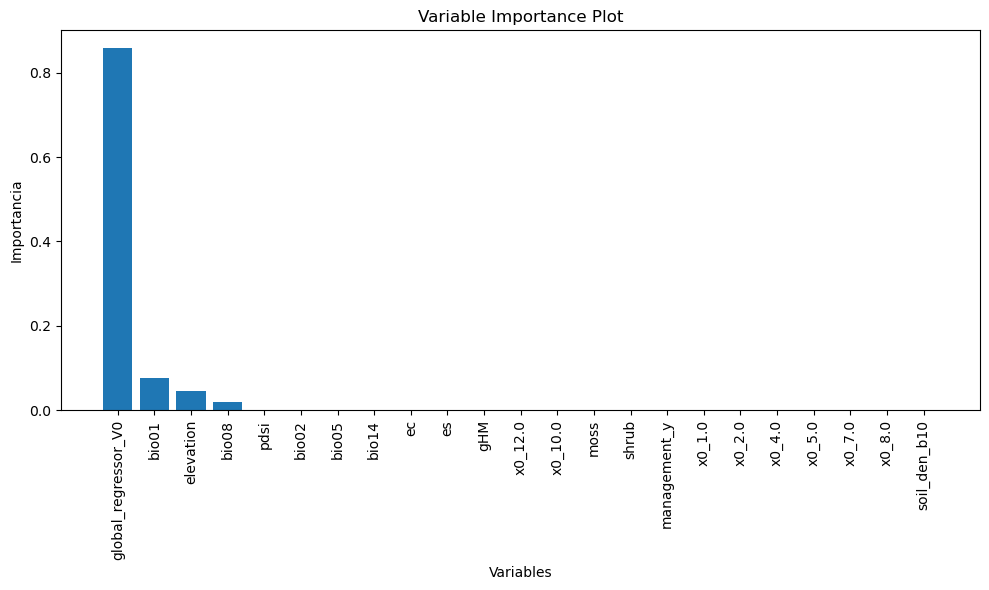

In [115]:
# Paso 2: Obtén la importancia de las variables desde el modelo
feature_importance_GB_CNN = best_model_GB_CNN.feature_importances_

# Paso 3: Crea un gráfico de barras para visualizar la importancia de las variables
# Puedes ordenar las variables por importancia si lo deseas
sorted_idx_GB_CNN = np.argsort(feature_importance_GB_CNN)[::-1]  # Orden descendente

# Obtén los nombres de las características (columnas) si los tienes
feature_names_GB_CNN = list(X_train_GB_CNN.columns)  # Reemplaza con tus nombres de características reales

# Crea el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_idx_GB_CNN)), feature_importance_GB_CNN[sorted_idx_GB_CNN], align='center')
plt.xticks(range(len(sorted_idx_GB_CNN)), [feature_names_GB_CNN[i] for i in sorted_idx_GB_CNN], rotation=90)
plt.xlabel('Variables')
plt.ylabel('Importancia')
plt.title('Variable Importance Plot')
plt.tight_layout()
plt.show()

In [84]:
X_train_GB_NO_CNN = df_ML_train_without_na[X_columns_NO_CNN]
X_test_GB_NO_CNN = df_ML_test_without_na[X_columns_NO_CNN]

# Crear una instancia de StandardScaler
scaler_GB_NO_CNN = StandardScaler()

# Ajustar el scaler solo con los datos de entrenamiento y luego transformar los datos de entrenamiento
X_train_GB_NO_CNN[columnas_a_escalar_NO_CNN] = scaler_GB_NO_CNN.fit_transform(X_train_GB_NO_CNN[columnas_a_escalar_NO_CNN])

# Aplicar la transformación a los datos de prueba usando los valores ajustados de los datos de entrenamiento
X_test_GB_NO_CNN[columnas_a_escalar_NO_CNN] = scaler_GB_NO_CNN.transform(X_test_GB_NO_CNN[columnas_a_escalar_NO_CNN])

y_train = df_ML_train_without_na[y_columns]
y_test = df_ML_test_without_na[y_columns]

C:\Users\alfon\AppData\Local\Temp\ipykernel_21052\1795673236.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_GB_NO_CNN[columnas_a_escalar_NO_CNN] = scaler_GB_NO_CNN.fit_transform(X_train_GB_NO_CNN[columnas_a_escalar_NO_CNN])
C:\Users\alfon\AppData\Local\Temp\ipykernel_21052\1795673236.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_GB_NO_CNN[columnas_a_escalar_NO_CNN] = scaler_GB_NO_CNN.transform(X_test_GB_NO_CNN[columnas_a_escalar_NO_CNN])


In [85]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform, randint

# Definir el espacio de hiperparámetros a explorar
param_dist = {
    'loss': ['ls', 'lad', 'huber', 'quantile'],
    'learning_rate': uniform(loc=0, scale=1),
    'n_estimators': randint(50, 600),  # Utilizamos randint para valores enteros en un rango
    'subsample': uniform(loc=0, scale=1),
    'min_samples_split': uniform(loc=0, scale=1),
    'min_samples_leaf': uniform(loc=0, scale=0.5),
    'min_weight_fraction_leaf': uniform(loc=0, scale=0.5),
    'max_depth': [2, 4, 8, 16, 32],
    'min_impurity_decrease': uniform(loc=0, scale=1),
    'max_features': uniform(loc=0, scale=1),
    'alpha': uniform(loc=0, scale=1),
    'max_leaf_nodes': [8, 16, 32, 64],
    'ccp_alpha': uniform(loc=0, scale=1)
}
# Crear una instancia del modelo Gradient Boosting
model_GB_NO_CNN = GradientBoostingRegressor()

# Número de iteraciones aleatorias
n_iter = 10000

# Crear un objeto RandomizedSearchCV para búsqueda aleatoria
random_search_GB_NO_CNN = RandomizedSearchCV(model_GB_NO_CNN, param_distributions=param_dist, cv = myCViterator, scoring='neg_mean_absolute_error', n_iter= n_iter,
                                verbose=2, random_state=135, n_jobs=4)

# Realizar la búsqueda aleatoria en el espacio de hiperparámetros
random_search_GB_NO_CNN.fit(X_train_GB_NO_CNN, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params_GB_NO_CNN = random_search_GB_NO_CNN.best_params_
print(f"Mejores hiperparámetros: {random_search_GB_NO_CNN}")

# Obtener el mejor modelo ajustado
best_model_GB_NO_CNN = random_search_GB_NO_CNN.best_estimator_

Fitting 5 folds for each of 10000 candidates, totalling 50000 fits


C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
24880 fits failed out of a total of 50000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3237 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\alfon\anaconda3\Lib\site-p

Mejores hiperparámetros: RandomizedSearchCV(cv=[(array([  0,   1,   2,   3,   4,   5,   6,   7,  17,  18,  19,  20,  21,
        22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,
        35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
        48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
        61,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,...
                                        'min_weight_fraction_leaf': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000127CBDC0550>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000127CBC2F690>,
                                        'subsample': <scipy.stats._distn_inf

In [86]:
best_model_GB_NO_CNN

GradientBoostingRegressor(alpha=0.7803773529855349,
                          ccp_alpha=0.016619697294130265,
                          learning_rate=0.5640852751132479, loss='huber',
                          max_depth=4, max_features=0.7590819405309432,
                          max_leaf_nodes=64,
                          min_impurity_decrease=0.25066725265266,
                          min_samples_leaf=0.0038762134778104196,
                          min_samples_split=0.6387103626570757,
                          min_weight_fraction_leaf=0.1036650715121441,
                          n_estimators=289, subsample=0.8756304510429398)

In [87]:
# make predictions
y_pred_GB_NO_CNN = best_model_GB_NO_CNN.predict(X_test_GB_NO_CNN)

# Evaluation of our best model
mae_GB_NO_CNN = mean_absolute_error(y_test, y_pred_GB_NO_CNN)
mse_GB_NO_CNN = mean_squared_error(y_test, y_pred_GB_NO_CNN)
rmse_GB_NO_CNN = np.sqrt(mse_GB_NO_CNN)
r2_GB_NO_CNN = r2_score(y_test, y_pred_GB_NO_CNN)

# Estimate spearman rho
coef_spearman_GB_NO_CNN, p_valor_spearman_GB_NO_CNN = spearmanr(y_test, y_pred_GB_NO_CNN)

# Best model results
# print("Model coefficients:", best_model_GB_NO_CNN.coef_)
# print("Intercept:", best_model_GB_NO_CNN.intercept_)
print("Mean square error (MSE):", mse_GB_NO_CNN)
print("Root mean square error (RMSE):", rmse_GB_NO_CNN)
print("R-squared:", r2_GB_NO_CNN)
print("Mean absolute error (MAE):", mae_GB_NO_CNN)
print("Spearman-rho:", coef_spearman_GB_NO_CNN,"(pvalor:",p_valor_spearman_GB_NO_CNN,")")

Mean square error (MSE): 1.5612392465702134
Root mean square error (RMSE): 1.249495596859074
R-squared: 0.23738640876031436
Mean absolute error (MAE): 1.0198927238789801
Spearman-rho: 0.5021780638255664 (pvalor: 5.859733057373942e-11 )


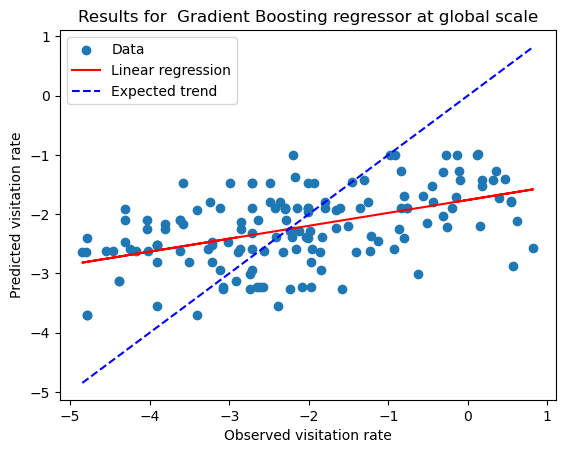

In [88]:
import matplotlib.pyplot as plt
import numpy as np

y_true = y_test.to_numpy()
y_true_array = y_true.flatten()
# fit a regression line with numpy
coef = np.polyfit(y_true_array, y_pred_GB_NO_CNN, 1)
poly1d_fn = np.poly1d(coef)

# create a scatter plot with regression line
plt.scatter(y_true_array, y_pred_GB_NO_CNN, label='Data')
plt.plot(y_true_array, poly1d_fn(y_true_array), color = 'red', label = 'Linear regression')
plt.plot(sorted(y_true_array), sorted(y_true_array), color = 'blue', linestyle = '--', label = 'Expected trend')

# Add labels
plt.xlabel('Observed visitation rate')
plt.ylabel('Predicted visitation rate')
plt.title('Results for  Gradient Boosting regressor at global scale')

# show legend
plt.legend()

# show plot
plt.show()

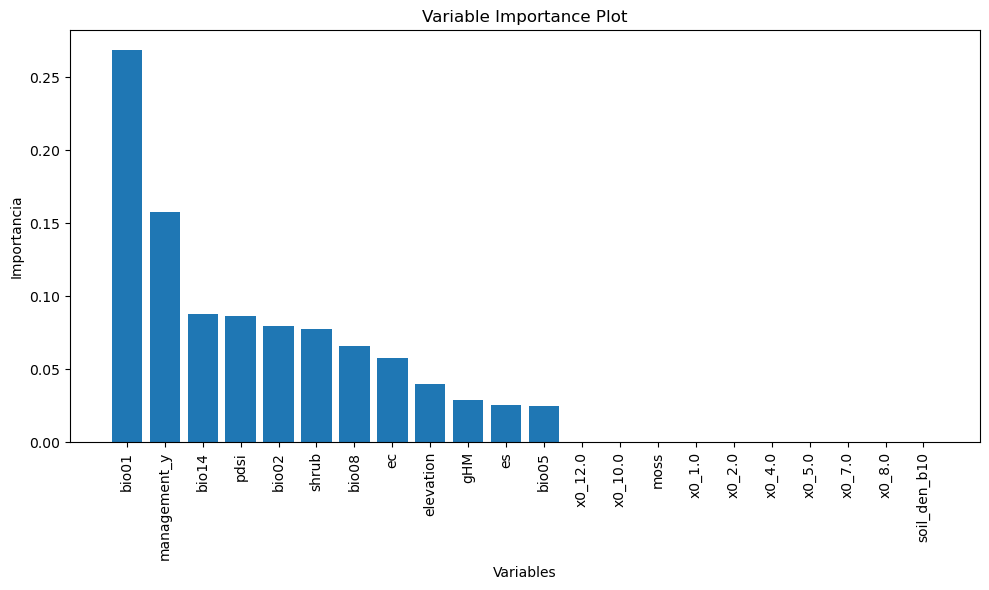

In [89]:
# Paso 2: Obtén la importancia de las variables desde el modelo
feature_importance_GB_NO_CNN = best_model_GB_NO_CNN.feature_importances_

# Paso 3: Crea un gráfico de barras para visualizar la importancia de las variables
# Puedes ordenar las variables por importancia si lo deseas
sorted_idx_GB_NO_CNN = np.argsort(feature_importance_GB_NO_CNN)[::-1]  # Orden descendente

# Obtén los nombres de las características (columnas) si los tienes
feature_names_GB_NO_CNN = list(X_train_GB_NO_CNN.columns)  # Reemplaza con tus nombres de características reales

# Crea el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_idx_GB_NO_CNN)), feature_importance_GB_NO_CNN[sorted_idx_GB_NO_CNN], align='center')
plt.xticks(range(len(sorted_idx_GB_NO_CNN)), [feature_names_GB_NO_CNN[i] for i in sorted_idx_GB_NO_CNN], rotation=90)
plt.xlabel('Variables')
plt.ylabel('Importancia')
plt.title('Variable Importance Plot')
plt.tight_layout()
plt.show()

In [90]:
y_pred_test_GB_NO_CNN = best_model_GB_NO_CNN.predict(X_test_GB_NO_CNN)
df_ML_test_without_na['GBoost'] = y_pred_test_GB_NO_CNN.flatten()

y_pred_train_GB_NO_CNN = best_model_GB_NO_CNN.predict(X_train_GB_NO_CNN)
df_ML_train_without_na['GBoost'] = y_pred_train_GB_NO_CNN.flatten()

C:\Users\alfon\AppData\Local\Temp\ipykernel_21052\445558237.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ML_test_without_na['GBoost'] = y_pred_test_GB_NO_CNN.flatten()
C:\Users\alfon\AppData\Local\Temp\ipykernel_21052\445558237.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ML_train_without_na['GBoost'] = y_pred_train_GB_NO_CNN.flatten()


In [101]:
X_columns_stack2 = ['global_regressor_V0','BayReg','GBoost']
y_columns = ['log_vr_total']

X_train_stack2 = df_ML_train_without_na[X_columns_stack2]
X_test_stack2 = df_ML_test_without_na[X_columns_stack2]

# Escalar las columnas seleccionadas
columnas_a_escalar_stack2 = ['global_regressor_V0','BayReg','GBoost']


# Crear una instancia de StandardScaler
scaler_stack2 = StandardScaler()

# Escalar las columnas seleccionadas para los datos de entrenamiento
X_train_stack2[columnas_a_escalar_stack2] = scaler_stack2.fit_transform(X_train_stack2[columnas_a_escalar_stack2])

# Aplicar la transformación a los datos de prueba con el mismo scaler
X_test_stack2[columnas_a_escalar_stack2] = scaler_stack2.transform(X_test_stack2[columnas_a_escalar_stack2])

y_train = df_ML_train_without_na[y_columns]
y_test = df_ML_test_without_na[y_columns]

C:\Users\alfon\AppData\Local\Temp\ipykernel_21052\1128513310.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_stack2[columnas_a_escalar_stack2] = scaler_stack2.fit_transform(X_train_stack2[columnas_a_escalar_stack2])
C:\Users\alfon\AppData\Local\Temp\ipykernel_21052\1128513310.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_stack2[columnas_a_escalar_stack2] = scaler_stack2.transform(X_test_stack2[columnas_a_escalar_stack2])


In [106]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform, randint

# Definir el espacio de hiperparámetros a explorar
param_dist = {
    'loss': ['ls', 'lad', 'huber', 'quantile'],
    'learning_rate': uniform(loc=0, scale=1),
    'n_estimators': randint(50, 600),  # Utilizamos randint para valores enteros en un rango
    'subsample': uniform(loc=0, scale=1),
    'min_samples_split': uniform(loc=0, scale=1),
    'min_samples_leaf': uniform(loc=0, scale=0.5),
    'min_weight_fraction_leaf': uniform(loc=0, scale=0.5),
    'max_depth': [2, 4, 8, 16, 32, 64],
    'min_impurity_decrease': uniform(loc=0, scale=1),
    'max_features': uniform(loc=0, scale=1),
    'alpha': uniform(loc=0, scale=1),
    'max_leaf_nodes': [8, 16, 32, 64],
    'ccp_alpha': uniform(loc=0, scale=1)
}
# Crear una instancia del modelo Gradient Boosting
model_stack2 = GradientBoostingRegressor()

# Número de iteraciones aleatorias
n_iter = 25000

# Crear un objeto RandomizedSearchCV para búsqueda aleatoria
random_search_stack2 = RandomizedSearchCV(model_stack2, param_distributions=param_dist, cv = myCViterator, scoring='neg_mean_absolute_error', n_iter= n_iter,verbose=2, random_state=135, n_jobs=8)

# Realizar la búsqueda aleatoria en el espacio de hiperparámetros
random_search_stack2.fit(X_train_stack2, y_train)

# Obtener los mejores hiperparámetros encontrados
best_params_stack2 = random_search_stack2.best_params_
print(f"Mejores hiperparámetros: {random_search_stack2}")

# Obtener el mejor modelo ajustado
best_model_stack2 = random_search_stack2.best_estimator_

Fitting 5 folds for each of 25000 candidates, totalling 125000 fits


C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
63515 fits failed out of a total of 125000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7902 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\alfon\anaconda3\Lib\site-

C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan ... -1.18272517 -1.17881131
         nan]
  warnings.warn(
C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mejores hiperparámetros: RandomizedSearchCV(cv=[(array([  0,   1,   2,   3,   4,   5,   6,   7,  17,  18,  19,  20,  21,
        22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,
        35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
        48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
        61,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,...
                                        'min_weight_fraction_leaf': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000127CC537910>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000127CEF7E690>,
                                        'subsample': <scipy.stats._distn_inf

In [107]:
best_model_stack2

GradientBoostingRegressor(alpha=0.8266995066703539,
                          ccp_alpha=0.0004975378670870612,
                          learning_rate=0.1398814536839862, loss='huber',
                          max_depth=4, max_features=0.6334491385353208,
                          max_leaf_nodes=64,
                          min_impurity_decrease=0.05631041736378317,
                          min_samples_leaf=0.0629511859409404,
                          min_samples_split=0.8896940152089193,
                          min_weight_fraction_leaf=0.1112806107918522,
                          n_estimators=72, subsample=0.9871233468453475)

In [108]:
# make predictions
y_pred_stack2 = best_model_stack2.predict(X_test_stack2)

# Evaluation of our best model
mae_stack2 = mean_absolute_error(y_test, y_pred_stack2)
mse_stack2 = mean_squared_error(y_test, y_pred_stack2)
rmse_stack2 = np.sqrt(mse_stack2)
r2_stack2 = r2_score(y_test, y_pred_stack2)

# Estimate spearman rho
coef_spearman_stack2, p_valor_spearman_stack2 = spearmanr(y_test, y_pred_stack2)

# Best model results
# print("Model coefficients:", best_model_NO_CNN.coef_)
# print("Intercept:", best_model_NO_CNN.intercept_)
print("Mean square error (MSE):", mse_stack2)
print("Root mean square error (RMSE):", rmse_stack2)
print("R-squared:", r2_stack2)
print("Mean absolute error (MAE):", mae_stack2)
print("Spearman-rho:", coef_spearman_stack2,"(pvalor:",p_valor_spearman_stack2,")")

Mean square error (MSE): 1.25423495772921
Root mean square error (RMSE): 1.119926317991148
R-squared: 0.3873478216272782
Mean absolute error (MAE): 0.9190869859348535
Spearman-rho: 0.6023429411643071 (pvalor: 3.5223644589442413e-16 )


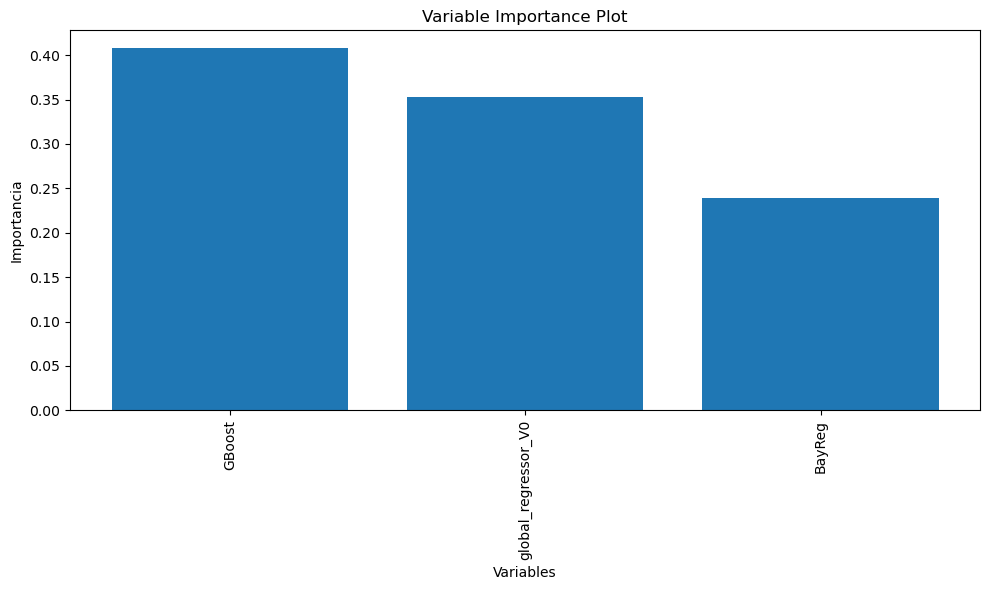

In [109]:
# Paso 2: Obtén la importancia de las variables desde el modelo
feature_importance_stack2 = best_model_stack2.feature_importances_

# Paso 3: Crea un gráfico de barras para visualizar la importancia de las variables
# Puedes ordenar las variables por importancia si lo deseas
sorted_idx_stack2 = np.argsort(feature_importance_stack2)[::-1]  # Orden descendente

# Obtén los nombres de las características (columnas) si los tienes
feature_names_stack2 = list(X_train_stack2.columns)  # Reemplaza con tus nombres de características reales

# Crea el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_idx_stack2)), feature_importance_stack2[sorted_idx_stack2], align='center')
plt.xticks(range(len(sorted_idx_stack2)), [feature_names_stack2[i] for i in sorted_idx_stack2], rotation=90)
plt.xlabel('Variables')
plt.ylabel('Importancia')
plt.title('Variable Importance Plot')
plt.tight_layout()
plt.show()

In [96]:
X_columns_stack3 = ['global_regressor_V0','BayReg','GBoost']
y_columns = ['log_vr_total']

X_train_stack3 = df_ML_train_without_na[X_columns_stack3]
X_test_stack3 = df_ML_test_without_na[X_columns_stack3]

# Escalar las columnas seleccionadas
columnas_a_escalar_stack3 = ['global_regressor_V0','BayReg','GBoost']

# Crear una instancia de StandardScaler
scaler_stack3 = StandardScaler()

# Escalar las columnas seleccionadas para los datos de entrenamiento
X_train_stack3[columnas_a_escalar_stack3] = scaler_stack3.fit_transform(X_train_stack3[columnas_a_escalar_stack3])

# Aplicar la transformación a los datos de prueba con el mismo scaler
X_test_stack3[columnas_a_escalar_stack3] = scaler_stack3.transform(X_test_stack3[columnas_a_escalar_stack3])


y_train = df_ML_train_without_na[y_columns]
y_test = df_ML_test_without_na[y_columns]

C:\Users\alfon\AppData\Local\Temp\ipykernel_21052\2818166627.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_stack3[columnas_a_escalar_stack3] = scaler_stack3.fit_transform(X_train_stack3[columnas_a_escalar_stack3])
C:\Users\alfon\AppData\Local\Temp\ipykernel_21052\2818166627.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_stack3[columnas_a_escalar_stack3] = scaler_stack3.transform(X_test_stack3[columnas_a_escalar_stack3])


In [97]:
# Model definition
model_bayesian_ridge_stack3 = BayesianRidge(n_iter=10000)

# Definir la cuadrícula de hiperparámetros a explorar
param_grid = {
    'alpha_1': uniform(loc=0, scale=0.5),
    'alpha_2': uniform(loc=0, scale=0.5),
    'lambda_1': uniform(loc=0, scale=0.5),
    'lambda_2': uniform(loc=0, scale=0.5),
    'fit_intercept': [False, True]
}

# Cross validation strategy (here we use K-Fold)
cv = KFold(n_splits = 5, shuffle = True, random_state = 42)

# Random search of best hyperparameter combinations
grid_search_stack3 = RandomizedSearchCV(model_bayesian_ridge_stack3, param_distributions = param_grid, cv = myCViterator,
                            scoring = 'neg_mean_absolute_error', n_iter = 10000,
                            verbose = 2, random_state = 135, n_jobs = 4)

grid_search_stack3.fit(X_train_stack3, y_train)

# best hyperparameter combination
best_hyperparameters_stack3 = grid_search_stack3.best_params_

# best model
best_model_stack3 = grid_search_stack3.best_estimator_


Fitting 5 folds for each of 10000 candidates, totalling 50000 fits


C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\linear_model\_bayes.py:53: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.3 and will be removed in 1.5
  warnings.warn(
C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [98]:
best_model_stack3

BayesianRidge(alpha_1=0.416319724711894, alpha_2=0.3273992641022507,
              lambda_1=0.49062237462945235, lambda_2=0.0030755717318939335,
              n_iter=10000)

In [99]:
# make predictions
y_pred_stack3 = best_model_stack3.predict(X_test_stack3)

# Evaluation of our best model
mae_stack3 = mean_absolute_error(y_test, y_pred_stack3)
mse_stack3 = mean_squared_error(y_test, y_pred_stack3)
rmse_stack3 = np.sqrt(mse_stack3)
r2_stack3 = r2_score(y_test, y_pred_stack3)

# Estimate spearman rho
coef_spearman_stack3, p_valor_spearman_stack3 = spearmanr(y_test, y_pred_stack3)

# Best model results
# print("Model coefficients:", best_model_NO_CNN.coef_)
# print("Intercept:", best_model_NO_CNN.intercept_)
print("Mean square error (MSE):", mse_stack3)
print("Root mean square error (RMSE):", rmse_stack3)
print("R-squared:", r2_stack3)
print("Mean absolute error (MAE):", mae_stack3)
print("Spearman-rho:", coef_spearman_stack3,"(pvalor:",p_valor_spearman_stack3,")")

Mean square error (MSE): 1.5700833965945549
Root mean square error (RMSE): 1.2530296870364066
R-squared: 0.23306633480217975
Mean absolute error (MAE): 1.0185705677948578
Spearman-rho: 0.48770296814592373 (pvalor: 2.454166099395025e-10 )


global_regressor_V0: VIP = 10.032330277187262
GBoost: VIP = 3.268709352466514
BayReg: VIP = 10.408386897430175


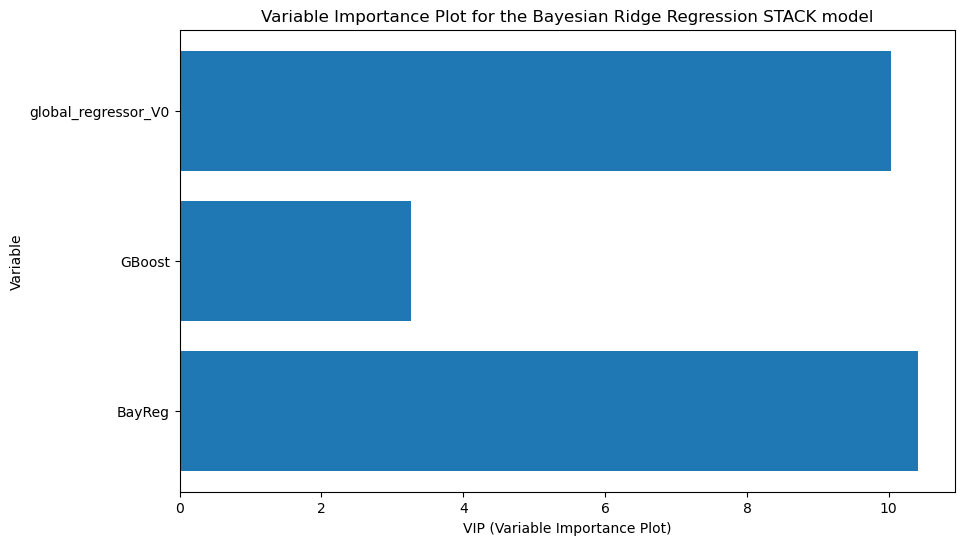

In [100]:
# Get coef. from the best model estimated
coeficients_stack3 = best_model_stack3.coef_

# Get variance from the estimated coeficients
variance_coefs_stack3 = np.var(coeficients_stack3)

# Estimate VIP for each variable
VIP_stack3 = np.abs(coeficients_stack3) / variance_coefs_stack3

# Sort VIP
sorted_indices_stack3 = np.argsort(VIP_stack3)[::-1]  # Sort from larger to smaller VIP
sorted_VIP_stack3 = VIP_NO_CNN[sorted_indices_stack3]

# Print VIP
for i, idx in enumerate(sorted_indices_stack3):
    print(f"{X_columns_stack3[idx]}: VIP = {sorted_VIP_stack3[i]}")
    
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_indices_stack3)), sorted_VIP_stack3, align='center')
plt.yticks(range(len(sorted_indices_stack3)), [X_columns_stack3[i] for i in sorted_indices_stack3])
plt.xlabel('VIP (Variable Importance Plot)')
plt.ylabel('Variable')
plt.title('Variable Importance Plot for the Bayesian Ridge Regression STACK model')
plt.gca().invert_yaxis()  # Invertir el eje y para que las variables más importantes estén arriba
plt.show()